# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=409376759808, percent=24.2, used=127726878720, free=410971381760, active=726851584, inactive=120151281664, buffers=4382720, cached=1706266624, shared=438304768, slab=1097334784)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp
import xskillscore as xs

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Functions

In [5]:
def compute_forecast_probabilities(ensemble_forecast, threshold_niño, threshold_niña):
        """
        Compute forecasted probabilities for binary events based on a threshold.
    
        Parameters:
        - ensemble_forecast: Array-like object of ensemble forecast values.
        - threshold: Threshold value to classify forecast values into binary events.
    
        Returns:
        - forecast_probabilities: Array of forecasted probabilities for each event.
        """
        forecast_probabilities_niño = np.mean(ensemble_forecast > threshold_niño, axis=0)
        forecast_probabilities_niña = np.mean(ensemble_forecast < threshold_niña, axis=0)
        return forecast_probabilities_niño, forecast_probabilities_niña
   

In [6]:
def plot_reliability_his(obs_niño, obs_niña, forecast_niño, forecast_niña, ax=None, title_kernel=None):
    """
    Plot a reliability diagram with a histogram of forecast probabilities.

    Parameters:
    - obs_niño: Array-like object of observed El Niño events (0 or 1).
    - obs_niña: Array-like object of observed La Niña events (0 or 1).
    - forecast_niño: Array-like object of forecasted probabilities for El Niño events.
    - forecast_niña: Array-like object of forecasted probabilities for La Niña events.
    - ax: Optional matplotlib axes to plot on. If not provided, a new figure will be created.

    Returns:
    - ax: Matplotlib axes containing the reliability diagram and histogram.
    """
    # Convert inputs to xarray DataArrays
    obs_da_niño = xr.DataArray(obs_niño)
    forecasts_da_niño = xr.DataArray(forecast_niño)
    # Calculate reliability
    reli_niño = xs.reliability(obs_da_niño, forecasts_da_niño, dim=None)

    # Convert inputs to xarray DataArrays
    obs_da_niña = xr.DataArray(obs_niña)
    forecasts_da_niña = xr.DataArray(forecast_niña)
    # Calculate reliability
    reli_niña = xs.reliability(obs_da_niña, forecasts_da_niña, dim=None)

    # Plot reliability diagram
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax_reliability = ax

    # Plot reliability diagrams for El Niño and La Niña events
    reli_niña.plot(ax=ax_reliability, marker='o', linestyle='-', label='La Niña')
    reli_niño.plot(ax=ax_reliability, marker='o', linestyle='-', label='El Niño')
    
    # Add perfect reliability line
    ax_reliability.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect reliability')

    # Add climatology line
    ax_reliability.plot([0, 1], [np.mean(obs_niño)] * 2, linestyle='--', color='red', label='Climatology (El Niño)')
    ax_reliability.plot([0, 1], [np.mean(obs_niña)] * 2, linestyle='--', color='blue', label='Climatology (La Niña)')

    # Set labels and title for reliability diagram
    ax_reliability.set_xlabel('')
    #ax_reliability.set_ylabel('Observed Frequency')
    ax_reliability.set_title(f'Lead={lead}',loc='right')
    ax_reliability.set_title(f'{title_kernel}',loc='left')
    ax_reliability.legend()
    ax_reliability.grid(True)

    # Plot histogram of forecast probabilities
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax_histogram = ax_reliability.twinx()
    # Plot histogram of forecast probabilities with adjusted position for El Niño
    ax_histogram.hist(forecast_niño.flatten(), bins=bins, alpha=0.2, color='red', label='El Niño', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='blue', hatch='//')
    ax_histogram.hist(forecast_niña.flatten(), bins=bins, alpha=0.2, color='blue', label='La Niña', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='red', hatch='//')
    #ax_histogram.set_ylabel('Density')
    ax_histogram.legend()

    return ax


In [7]:
def plot_reliability_his1(obs_niño, obs_niña, forecast_niño, forecast_niña, limit, ax=None, title_kernel=None, legend=False, ticks=False):
    """
    Plot a reliability diagram with a histogram of forecast probabilities.

    Parameters:
    - obs_niño: Array-like object of observed El Niño events (0 or 1).
    - obs_niña: Array-like object of observed La Niña events (0 or 1).
    - forecast_niño: Array-like object of forecasted probabilities for El Niño events.
    - forecast_niña: Array-like object of forecasted probabilities for La Niña events.
    - ax: Optional matplotlib axes to plot on. If not provided, a new figure will be created.

    Returns:
    - ax: Matplotlib axes containing the reliability diagram and histogram.
    """
    # Convert inputs to xarray DataArrays
    obs_da_niño = xr.DataArray(obs_niño)
    forecasts_da_niño = xr.DataArray(forecast_niño)
    # Calculate reliability
    reli_niño = xs.reliability(obs_da_niño, forecasts_da_niño, dim=None)

    # Convert inputs to xarray DataArrays
    obs_da_niña = xr.DataArray(obs_niña)
    forecasts_da_niña = xr.DataArray(forecast_niña)
    # Calculate reliability
    reli_niña = xs.reliability(obs_da_niña, forecasts_da_niña, dim=None)

    # Plot reliability diagram
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax_reliability = ax

    # Plot reliability diagrams for El Niño and La Niña events
    reli_niña.plot(ax=ax_reliability, marker='o', linestyle='-', label='La Niña')
    reli_niño.plot(ax=ax_reliability, marker='o', linestyle='-', label='El Niño')
    
    # Add perfect reliability line
    ax_reliability.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect reliability')

    # Add climatology line
    ax_reliability.plot([0, 1], [np.mean(obs_niño)] * 2, linestyle='--', color='red', label='Climatology (El Niño)')
    ax_reliability.plot([0, 1], [np.mean(obs_niña)] * 2, linestyle='--', color='blue', label='Climatology (La Niña)')

    # Set labels and title for reliability diagram
    ax_reliability.set_xlabel('')
    #ax_reliability.set_ylabel('Observed Frequency')
    ax_reliability.set_title(f'Lead={lead}',loc='right')
    ax_reliability.set_title(f'{title_kernel}',loc='left', weight='bold')
    if legend== True:
        ax_reliability.legend()
    ax_reliability.grid(True)

    # Plot histogram of forecast probabilities
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax_histogram = ax_reliability.twinx()
    # Plot histogram of forecast probabilities with adjusted position for El Niño
    ax_histogram.hist(forecast_niño.flatten(), bins=bins, alpha=0.2, color='red', label='El Niño', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='blue', hatch='//')
    ax_histogram.hist(forecast_niña.flatten(), bins=bins, alpha=0.2, color='blue', label='La Niña', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='red', hatch='//')
    #ax_histogram.set_ylabel('Density')
    if legend==True:
        ax_histogram.legend()

    if ticks==False:
        ax_histogram.yaxis.set_major_formatter(plt.NullFormatter())
        
    ax_histogram.set_ylim(0,limit)

    return ax


In [8]:
def plot_reliability_his_err(obs_niño, obs_niña, forecast_niño, forecast_niña, limit, ax=None, title_kernel=None, legend=False, ticks=False):
    """
    Plot a reliability diagram with a histogram of forecast probabilities.

    Parameters:
    - obs_niño: Array-like object of observed El Niño events (0 or 1).
    - obs_niña: Array-like object of observed La Niña events (0 or 1).
    - forecast_niño: Array-like object of forecasted probabilities for El Niño events.
    - forecast_niña: Array-like object of forecasted probabilities for La Niña events.
    - ax: Optional matplotlib axes to plot on. If not provided, a new figure will be created.

    Returns:
    - ax: Matplotlib axes containing the reliability diagram and histogram.
    """
    # Convert inputs to xarray DataArrays
    obs_da_niño = xr.DataArray(obs_niño)
    forecasts_da_niño = xr.DataArray(forecast_niño)
    # Calculate reliability
    reli_niño = xs.reliability(obs_da_niño, forecasts_da_niño, dim=None)

    # Convert inputs to xarray DataArrays
    obs_da_niña = xr.DataArray(obs_niña)
    forecasts_da_niña = xr.DataArray(forecast_niña)
    # Calculate reliability
    reli_niña = xs.reliability(obs_da_niña, forecasts_da_niña, dim=None)

    # Plot reliability diagram
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax_reliability = ax

    # Plot reliability diagrams for El Niño and La Niña events
    reli_niña.plot(ax=ax_reliability, marker='o', linestyle='-', label='La Niña')
    reli_niño.plot(ax=ax_reliability, marker='o', linestyle='-', label='El Niño')


    def calculate_confidence_interval(reliability, bin_counts):
        # Assuming reliability is a numpy array
        n = bin_counts
        se = np.sqrt(reliability * (1 - reliability) / n)
        #z = 1.96  # 95% confidence interval
        z = 2.57  # 99% confidence interval
        lower_bound = reliability - z * se
        upper_bound = reliability + z * se
        return lower_bound, upper_bound

    # Calculate number of observations within each bin
    bin_counts_niño, _ = np.histogram(forecast_niño, bins=5)
    bin_counts_niña, _ = np.histogram(forecast_niña, bins=5)
    
    ci_lower_niña, ci_upper_niña = calculate_confidence_interval(reli_niña.values, bin_counts_niña)
    ci_lower_niño, ci_upper_niño = calculate_confidence_interval(reli_niño.values, bin_counts_niño)
    

    
    # Plot confidence intervals with error bars
    thresholds = [0.1,0.3,0.5,0.7,0.9]
    ax_reliability.errorbar(thresholds, reli_niña.values, yerr=[reli_niña.values - ci_lower_niña, ci_upper_niña - reli_niña.values], fmt='', color='blue', capsize=5)
    ax_reliability.errorbar(thresholds, reli_niño.values, yerr=[reli_niño.values - ci_lower_niño, ci_upper_niño - reli_niño.values], fmt='', color='orange', capsize=5)

    
    # Add perfect reliability line
    ax_reliability.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect reliability')

    # Add climatology line
    ax_reliability.plot([0, 1], [np.mean(obs_niño)] * 2, linestyle='--', color='red', label='Climatology (El Niño)')
    ax_reliability.plot([0, 1], [np.mean(obs_niña)] * 2, linestyle='--', color='blue', label='Climatology (La Niña)')

    # Set labels and title for reliability diagram
    ax_reliability.set_xlabel('')
    #ax_reliability.set_ylabel('Observed Frequency')
    ax_reliability.set_title(f'Lead={lead}',loc='right')
    ax_reliability.set_title(f'{title_kernel}',loc='left', weight='bold')
    if legend== True:
        ax_reliability.legend()
    ax_reliability.grid(True)

    # Plot histogram of forecast probabilities
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax_histogram = ax_reliability.twinx()
    # Plot histogram of forecast probabilities with adjusted position for El Niño
    ax_histogram.hist(forecast_niño.flatten(), bins=bins, alpha=0.2, color='red', label='El Niño', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='blue', hatch='//')
    ax_histogram.hist(forecast_niña.flatten(), bins=bins, alpha=0.2, color='blue', label='La Niña', density=True, rwidth=0.5, align='mid', lw=1, edgecolor='red', hatch='//')
    #ax_histogram.set_ylabel('Density')
    if legend==True:
        ax_histogram.legend()

    if ticks==False:
        ax_histogram.yaxis.set_major_formatter(plt.NullFormatter())
        
    ax_histogram.set_ylim(0,limit)

    return ax


# Load and regrid data

In [9]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [10]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

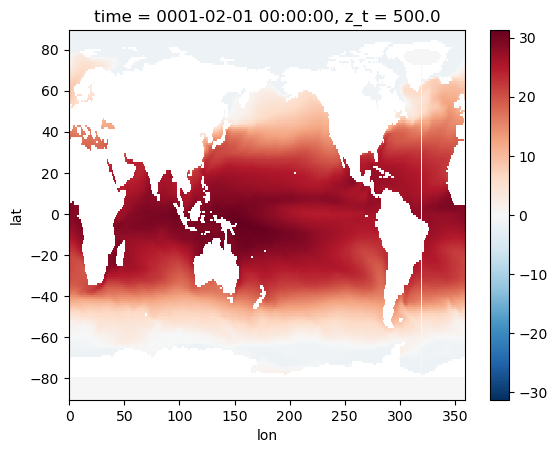

In [11]:
ds_tos.isel(time=0).plot()

## Subset data

In [12]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [13]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

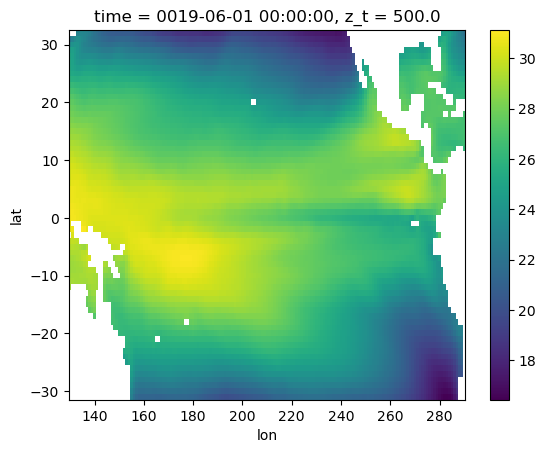

In [14]:
S_tos.isel(time=220).plot()

In [15]:
del(ds_tos, ds_ssh)

In [16]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=408780922880, percent=24.4, used=128304066560, free=410356899840, active=764260352, inactive=120725917696, buffers=4382720, cached=1743560704, shared=438308864, slab=1097314304)

## Create matrices, de-trending data and anomalies

In [17]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [18]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [19]:
del(S_tos,S_ssh)

In [20]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [21]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [22]:
del(X_ssh)

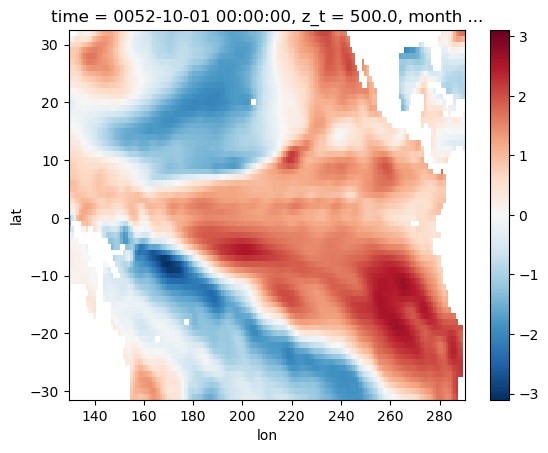

In [23]:
X_tos.A.unstack().isel(time=620).plot()

# 50 years

In [27]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [26]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

## ALL GAUSS

In [27]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [360]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [361]:
tot_for_union=np.empty((38, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [362]:
for m in lead_times:
    print(m)
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [363]:
tot_for_union.shape

(38, 845, 24, 24000)

### NIÑO AND NIÑA CURVES

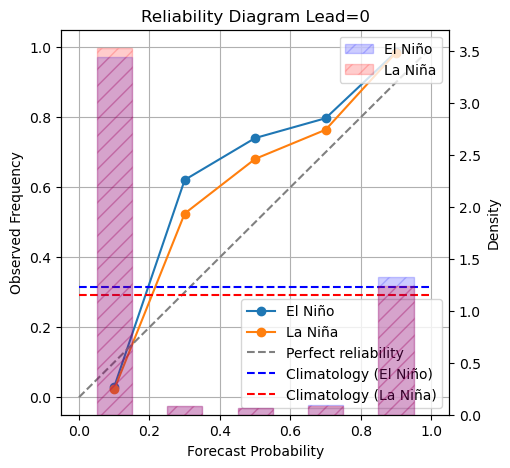

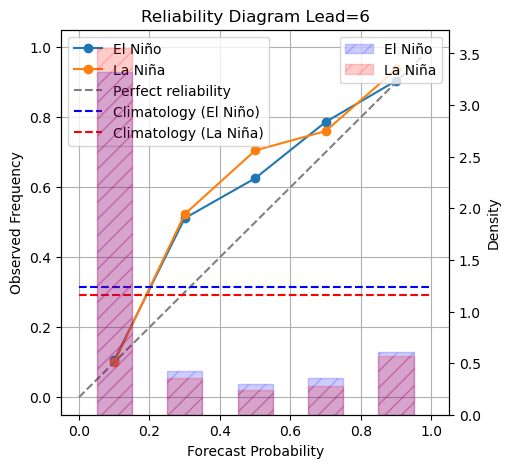

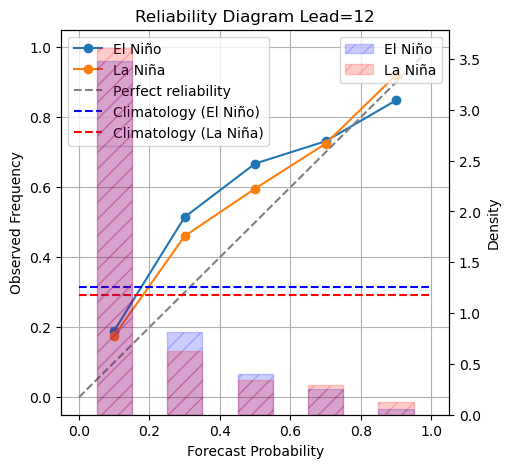

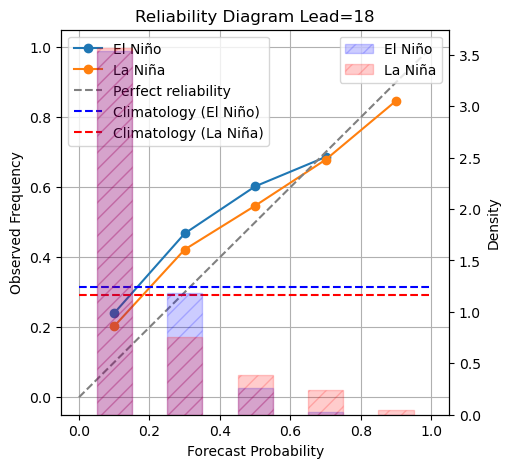

In [364]:
for lead in leads:
    
    FOR_index=np.zeros((38,24000))
    FOR_index.shape
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 GAUSS

In [365]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [366]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [367]:
tot_for=np.zeros((20, 38, 30, 24, 1176))

In [368]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 50/30EOFs_forecast_p{n}.npy')

In [369]:
tot_for_union=np.empty((38, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [370]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [371]:
del(tot_for)

In [372]:
tot_for_union.shape

(38, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

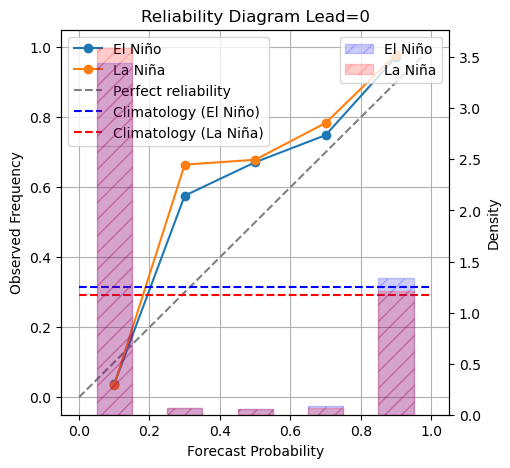

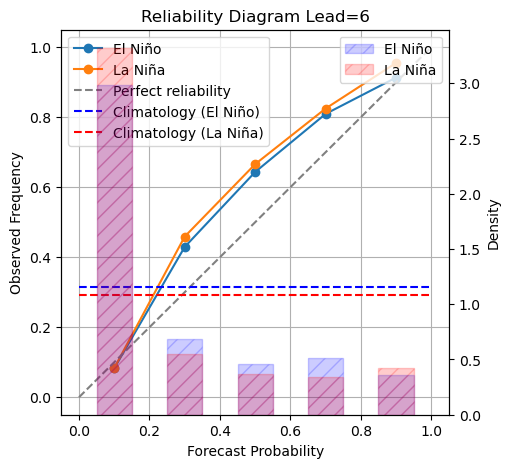

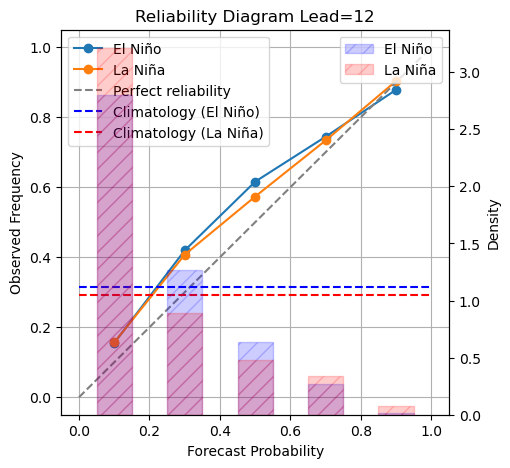

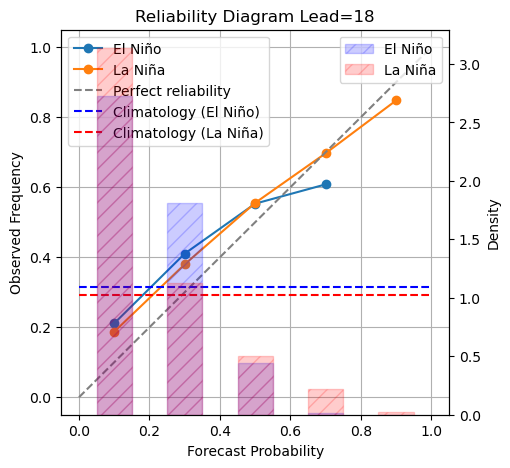

In [373]:
for lead in leads:
    
    FOR_index=np.zeros((38,24000))
    FOR_index.shape
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 POLY

In [374]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [375]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [376]:
tot_for=np.zeros((20, 38, 30, 24, 1176))

In [377]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 50/Poly_forecast_p{n}.npy')

In [378]:
tot_for_union=np.empty((38, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [379]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [380]:
del(tot_for)

### NIÑO AND NIÑA CURVES

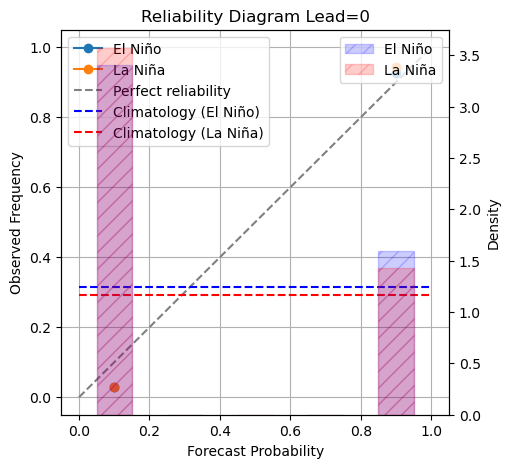

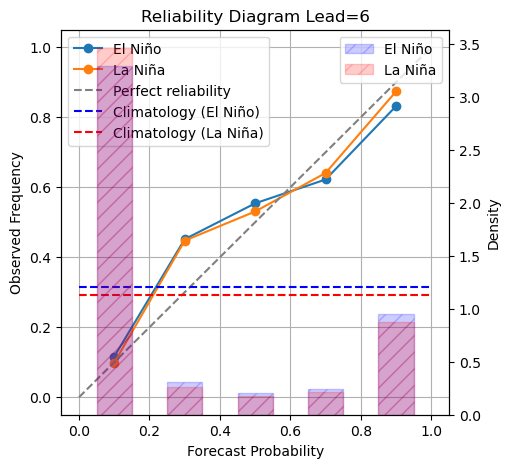

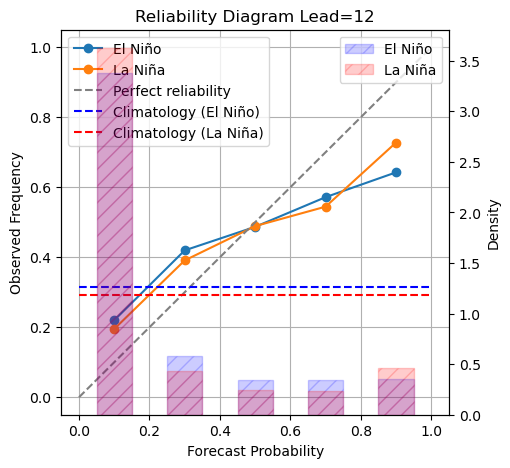

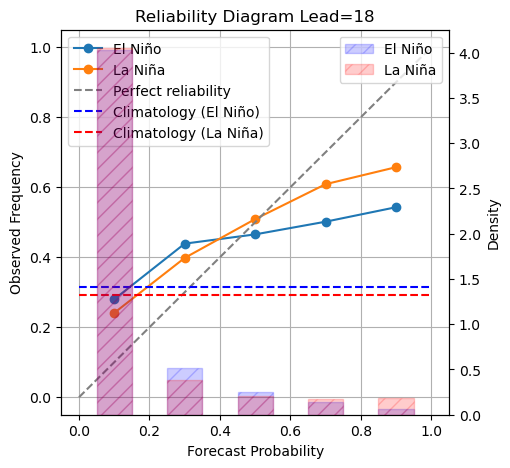

In [381]:
for lead in leads:
    
    FOR_index=np.zeros((38,24000))
    FOR_index.shape
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

# 100 years

In [28]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [29]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

## ALL GAUSS

In [30]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [31]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [32]:
tot_for=np.zeros((20, 19, 1845, 24, 1176))

In [33]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

KeyboardInterrupt: 

In [ ]:
tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [ ]:
del(tot_for)

In [ ]:
tot_for_union.shape

### NIÑO AND NIÑA CURVES

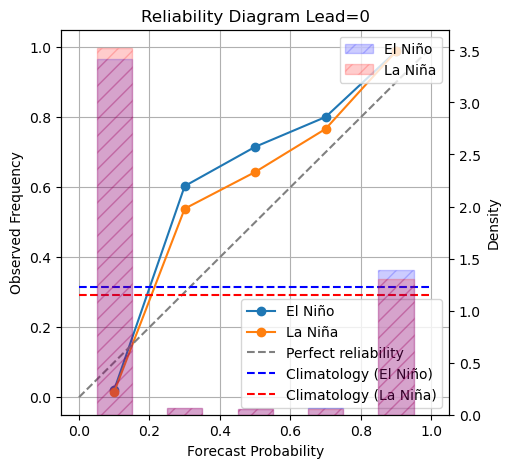

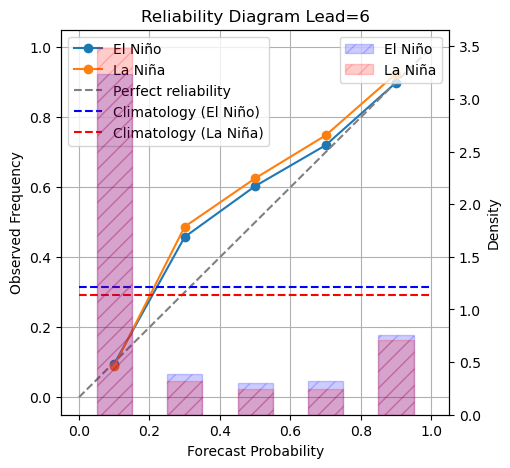

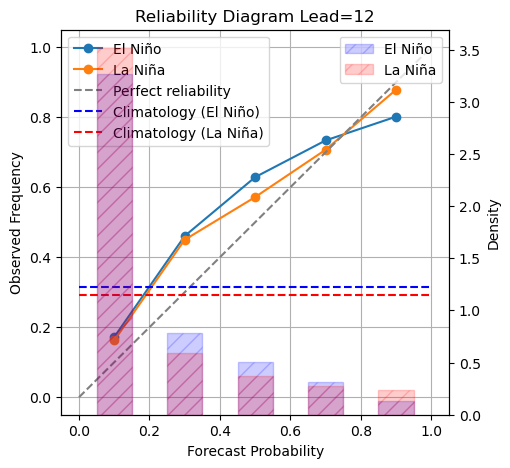

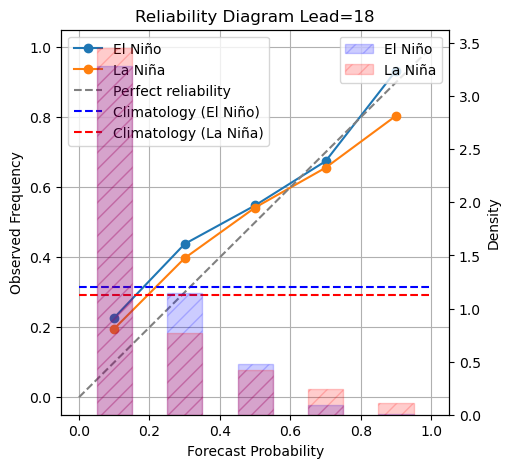

In [312]:
for lead in leads:
    
    FOR_index=np.zeros((19,24000))
    FOR_index.shape
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 GAUSS

In [313]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [314]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [315]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [316]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

In [317]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [318]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [319]:
del(tot_for)

In [320]:
tot_for_union.shape

(19, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

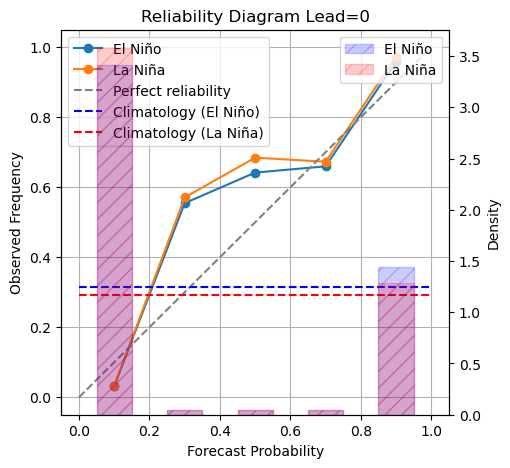

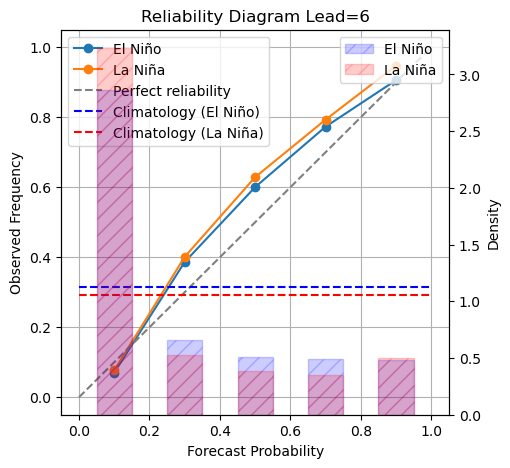

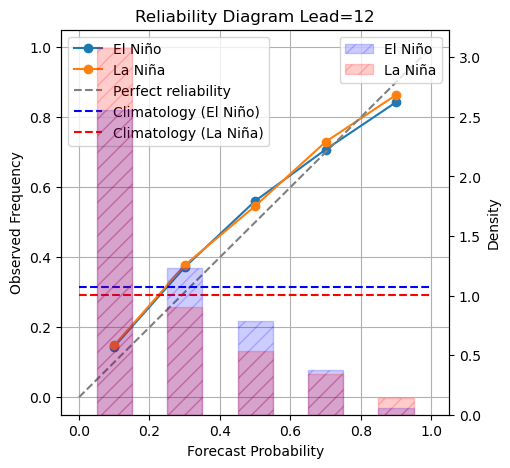

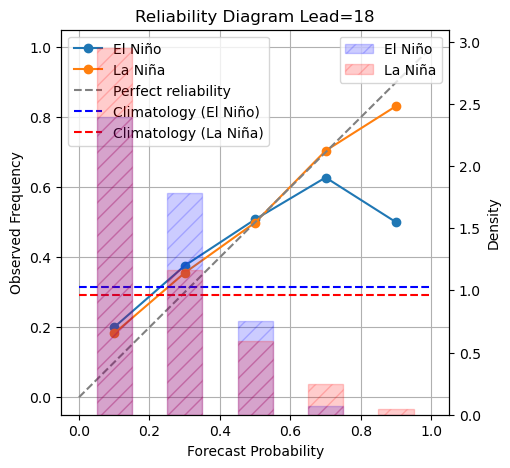

In [321]:
for lead in leads:
    
    FOR_index=np.zeros((19,24000))
    FOR_index.shape
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 POLY

In [322]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [323]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [324]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [325]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/Poly_forecast_p{n}.npy')

In [326]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [327]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [328]:
del(tot_for)

### NIÑO AND NIÑA CURVES

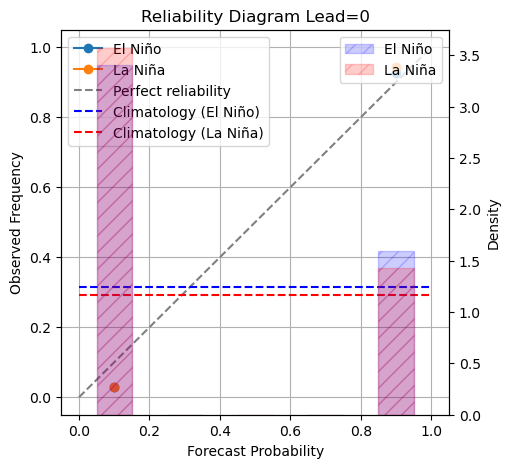

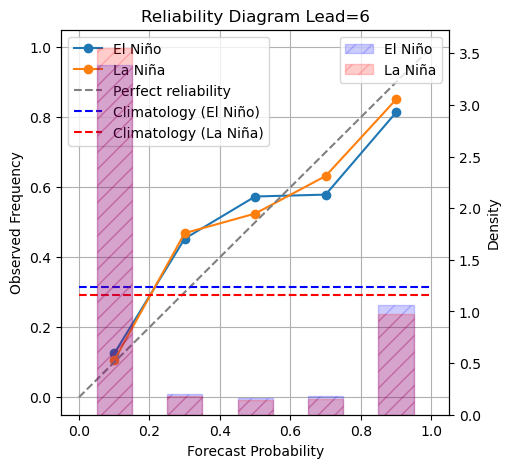

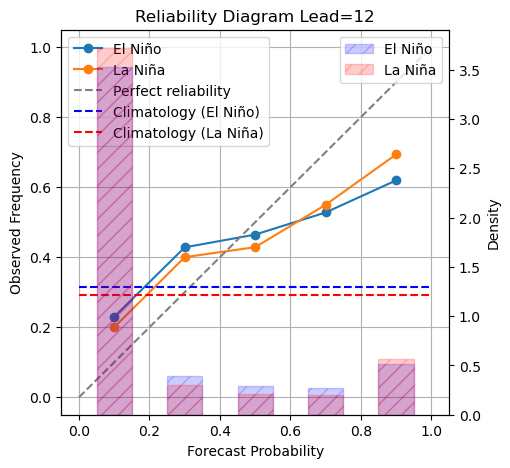

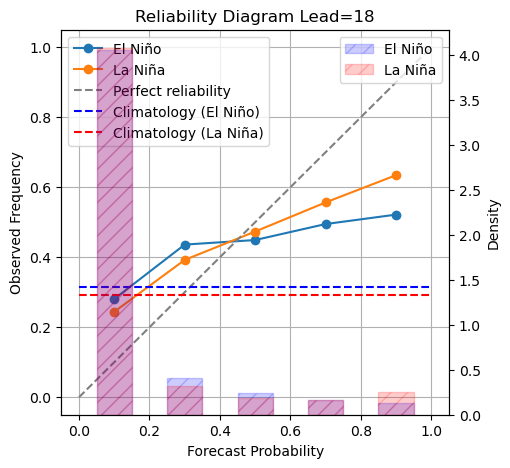

In [329]:
for lead in leads:
    
    FOR_index=np.zeros((19,24000))
    FOR_index.shape
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

# 200 years

In [ ]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [ ]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

## ALL GAUSS

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [273]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [274]:
tot_for=np.zeros((20, 17, 1845, 24, 1176))

In [275]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

In [276]:
tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [277]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [278]:
del(tot_for)

In [279]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]

In [280]:
tot_for_union.shape

(9, 1845, 24, 24000)

### NIÑO AND NIÑA CURVES

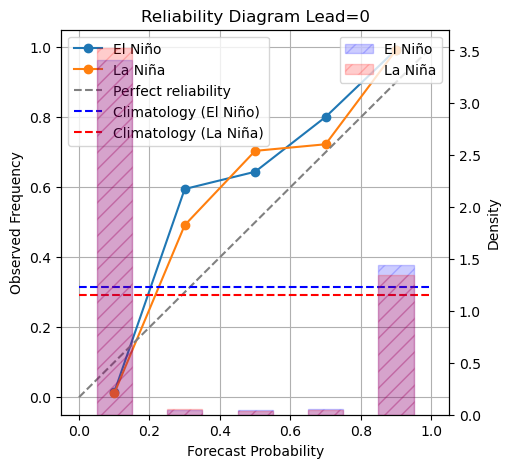

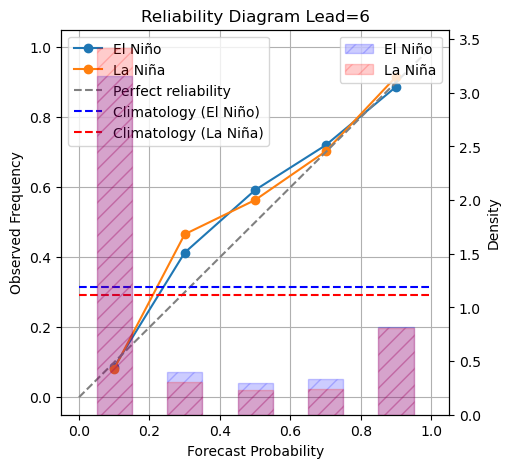

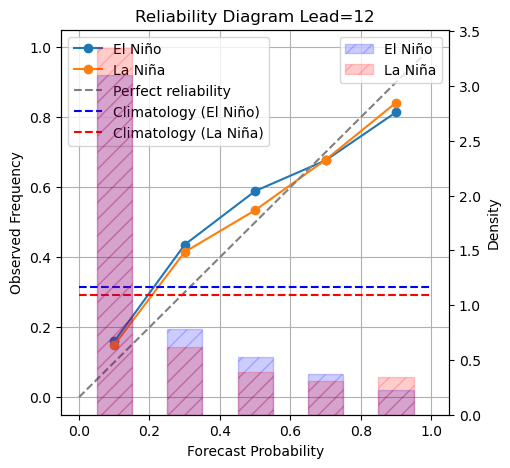

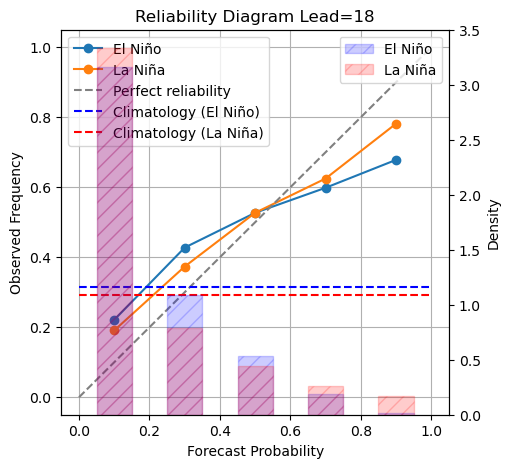

In [281]:
for lead in leads:
    
    FOR_index=np.zeros((9,24000))
    FOR_index.shape
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 GAUSS

In [282]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [283]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [284]:
tot_for=np.zeros((20, 17, 30, 24, 1176))

In [285]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/30EOFs_forecast_p{n}.npy')

In [286]:
tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [287]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [288]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]

In [289]:
del(tot_for)

In [290]:
tot_for_union.shape

(9, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

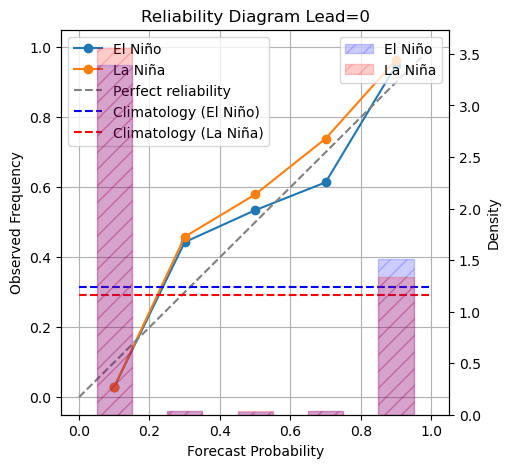

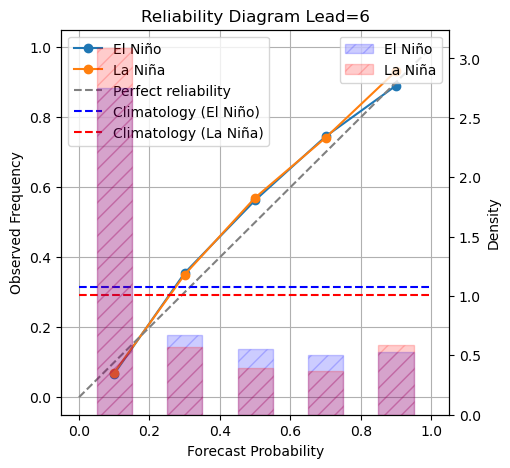

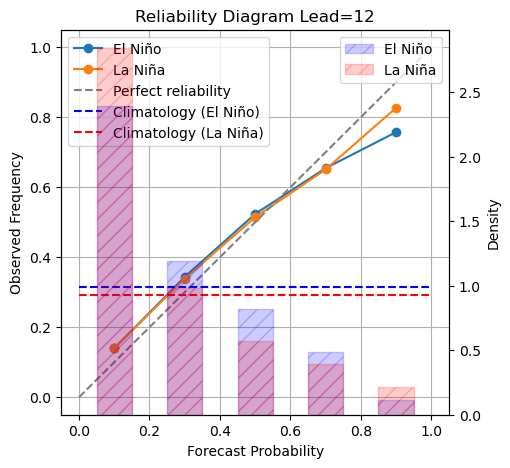

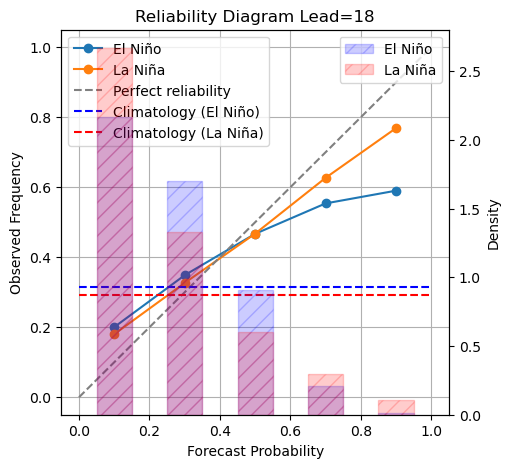

In [291]:
for lead in leads:
    
    FOR_index=np.zeros((9,24000))
    FOR_index.shape
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 POLY

In [292]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [293]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [294]:
tot_for=np.zeros((20, 17, 30, 24, 1176))

In [295]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

In [296]:
tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [297]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [298]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]

In [299]:
del(tot_for)

In [300]:
tot_for_union.shape

(9, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

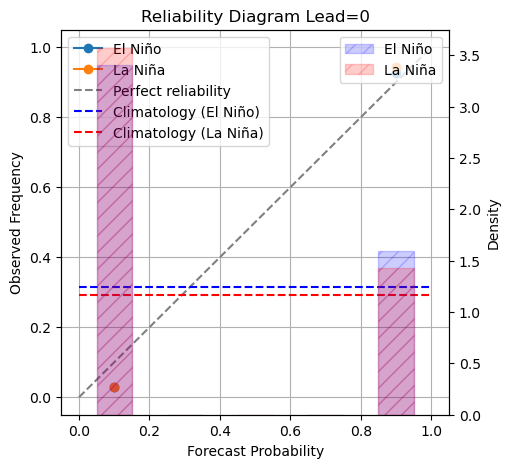

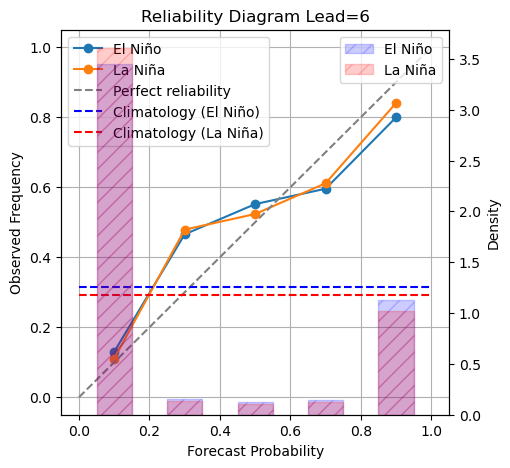

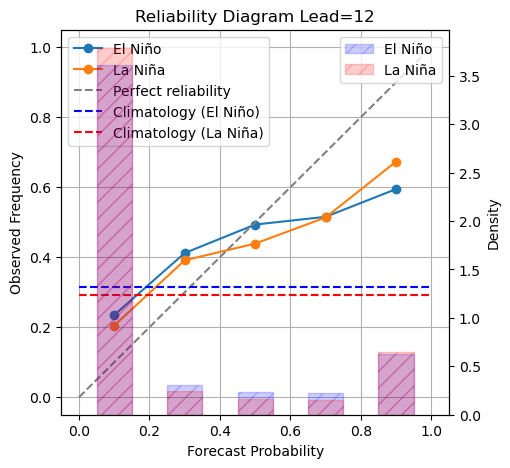

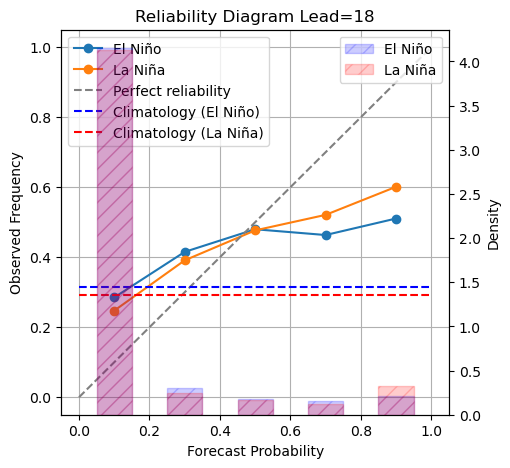

In [301]:
for lead in leads:
    
    FOR_index=np.zeros((9,24000))
    FOR_index.shape
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

# 400 years

In [34]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [35]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

## ALL GAUSS

In [24]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [25]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [26]:
tot_for=np.zeros((20, 7, 1845, 24, 1176))

In [27]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

In [28]:
tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [29]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [30]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [31]:
del(tot_for)

In [32]:
tot_for_union.shape

(4, 1845, 24, 24000)

### NIÑO AND NIÑA CURVES

In [33]:
lead=0

In [34]:
FOR_index=np.zeros((4,24000))
FOR_index.shape

for i in range(4):  
    phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    FOR_index[i,:]=Phiindex.data


# REMOVE NaNs
obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]

# BINARY OBSERVATIONS IN DATARRAY FORM
threshold=0.5
niño_binary = np.where(obs > threshold, 1, 0)
niña_binary = np.where(obs < -threshold, 1, 0)

# PROBABILISTIC FORECAST IN DATARRAY FORM    
niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)


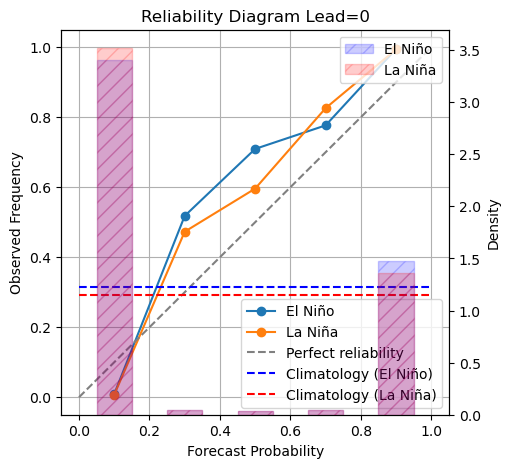

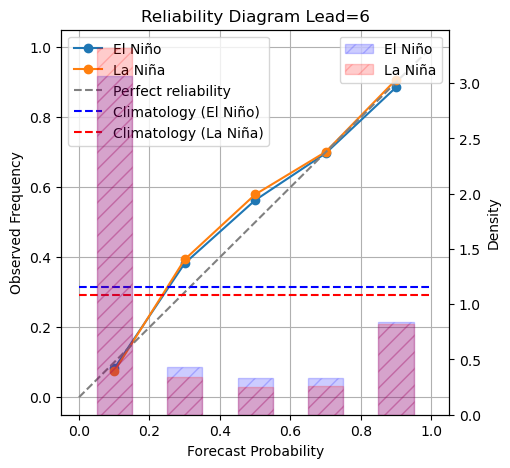

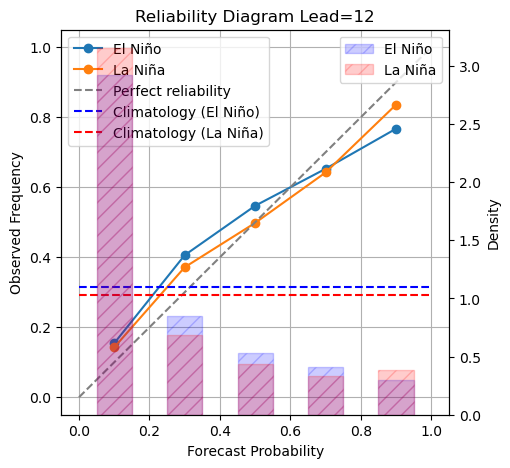

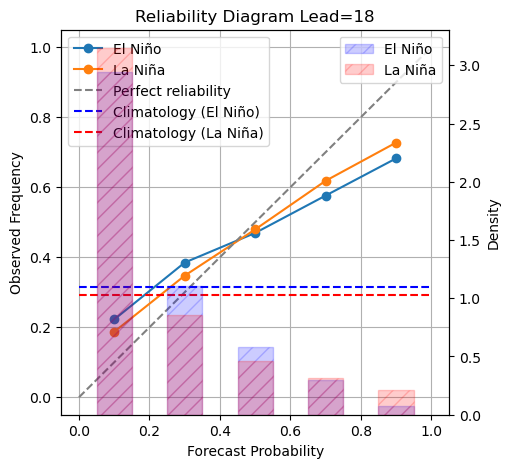

In [221]:
for lead in leads:
    
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 GAUSS

In [223]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [224]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [225]:
tot_for=np.zeros((20, 7, 30, 24, 1176))

In [226]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/30EOFs_forecast_p{n}.npy')

In [227]:
tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [228]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [229]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [230]:
del(tot_for)

In [231]:
tot_for_union.shape

(4, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

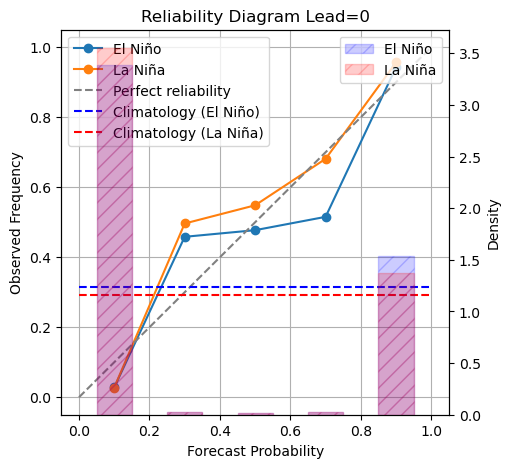

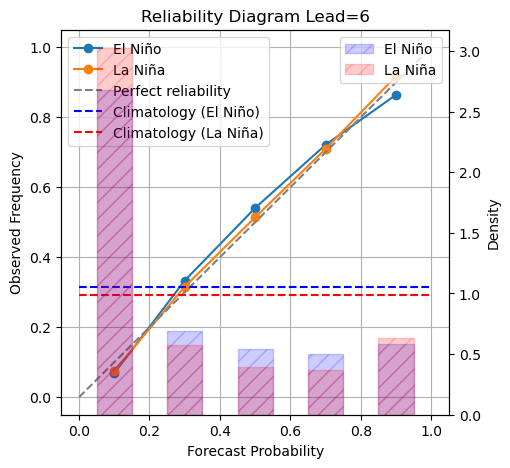

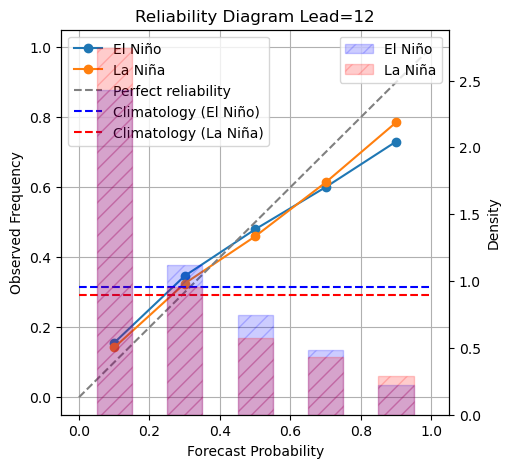

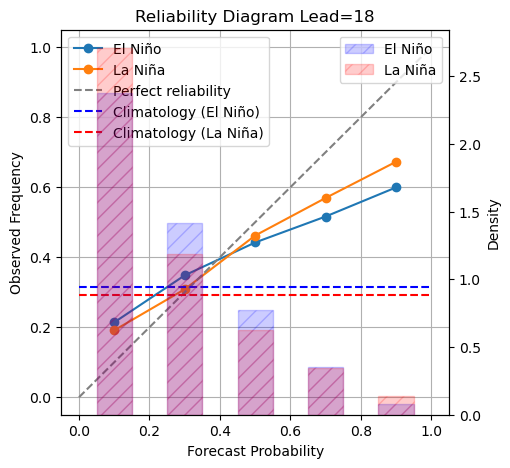

In [232]:
for lead in leads:
    
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 POLY

In [36]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [37]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

In [38]:
tot_for=np.zeros((20, 7, 30, 24, 1176))

In [39]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

In [40]:
tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [41]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [42]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [43]:
del(tot_for)

In [44]:
tot_for_union.shape

(4, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

In [45]:
for lead in leads:
    
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

NameError: name 'xs' is not defined

# 1000 years

## ALL GAUSS

In [243]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [244]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [245]:
tot_for=np.zeros((20, 1, 1845, 24, 1176))

In [246]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/ALLEOFs_forecast_p{n}.npy')

In [247]:
tot_for_union=np.empty((1, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [248]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [249]:
del(tot_for)

In [250]:
tot_for_union.shape

(1, 1845, 24, 24000)

### NIÑO AND NIÑA CURVES

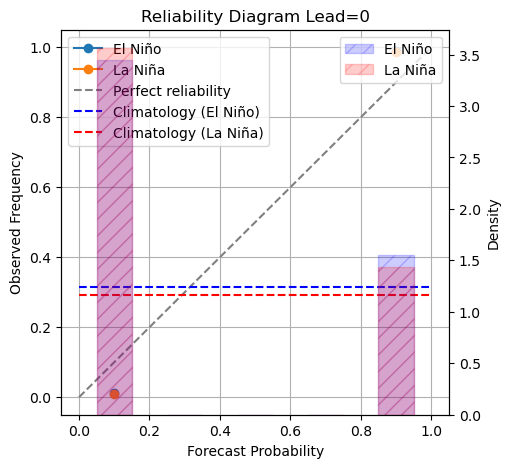

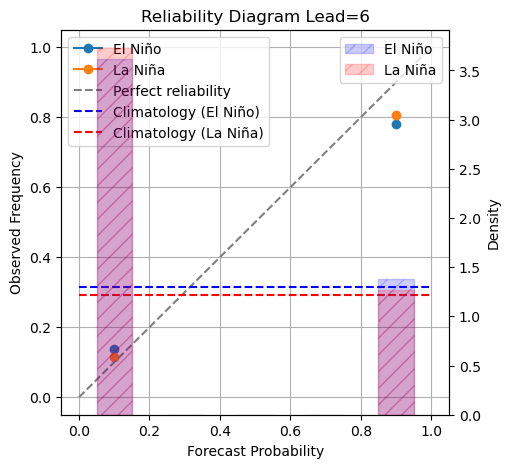

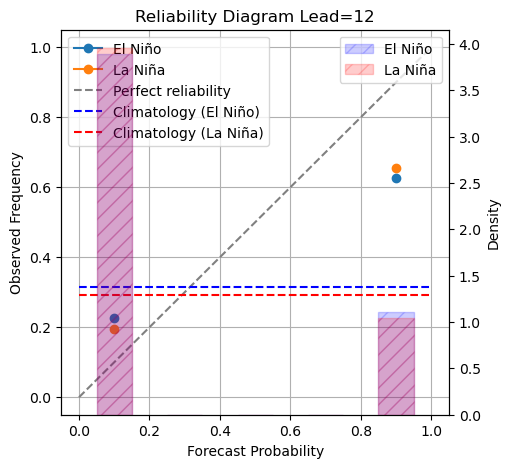

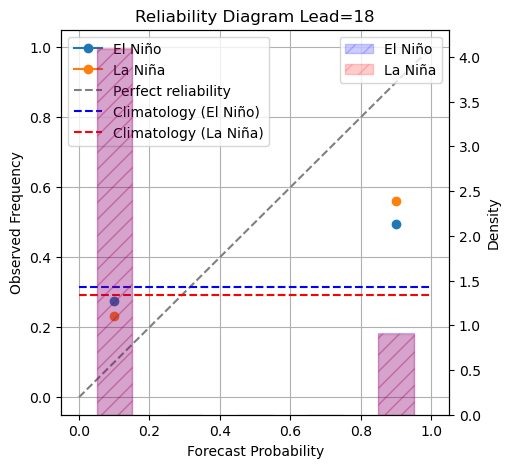

In [251]:
for lead in leads:
    
    FOR_index=np.zeros((1,24000))
    FOR_index.shape
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 GAUSS

In [252]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [253]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [254]:
tot_for=np.zeros((20, 1, 30, 24, 1176))

In [255]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/30EOFs_forecast_p{n}.npy')

In [256]:
tot_for_union=np.empty((1, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [257]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [258]:
del(tot_for)

In [259]:
tot_for_union.shape

(1, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

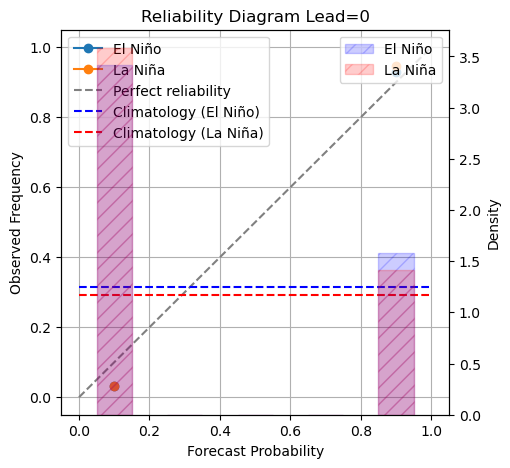

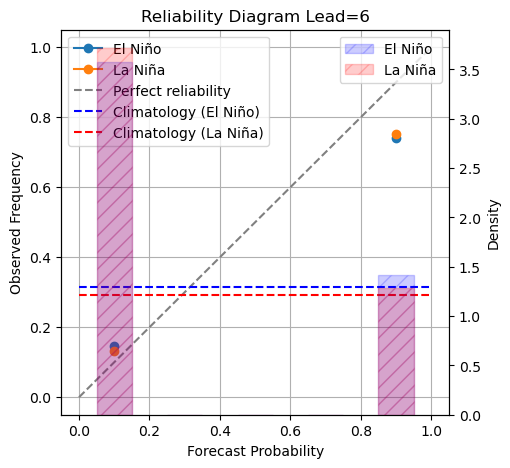

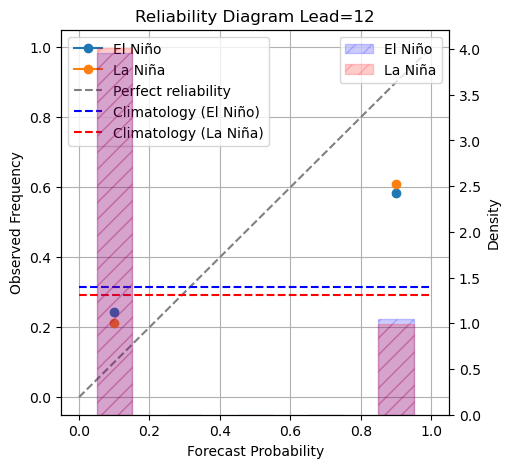

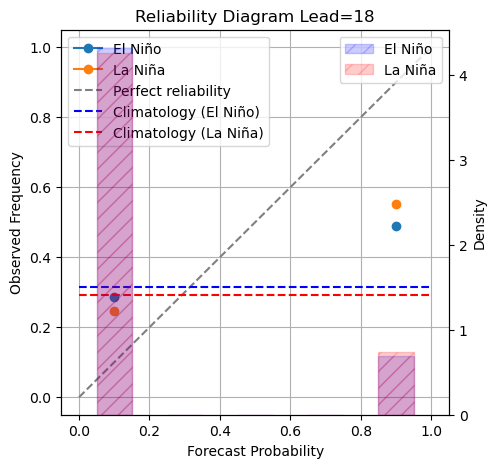

In [260]:
for lead in leads:
    
    FOR_index=np.zeros((1,24000))
    FOR_index.shape
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

## 30 POLY

In [261]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [262]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [263]:
tot_for=np.zeros((20, 1, 30, 24, 1176))

In [264]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/POLY_forecast_p{n}.npy')

In [265]:
tot_for_union=np.empty((1, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [266]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [267]:
del(tot_for)

In [268]:
tot_for_union.shape

(1, 30, 24, 24000)

### NIÑO AND NIÑA CURVES

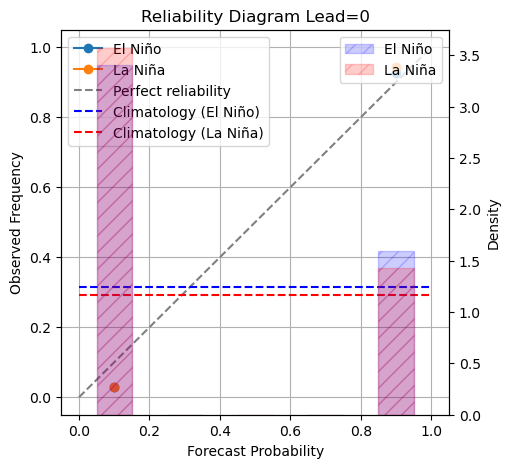

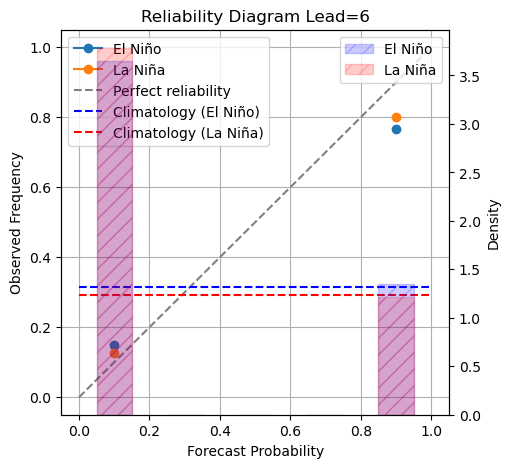

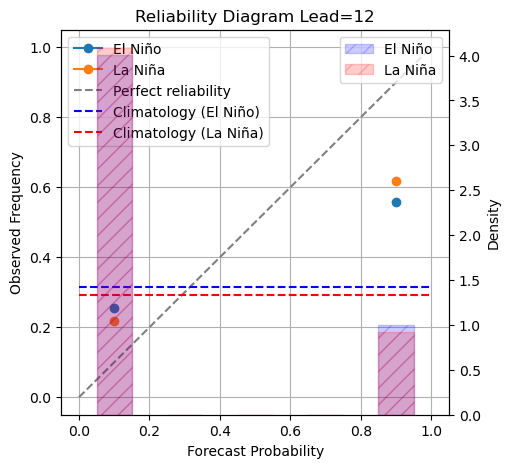

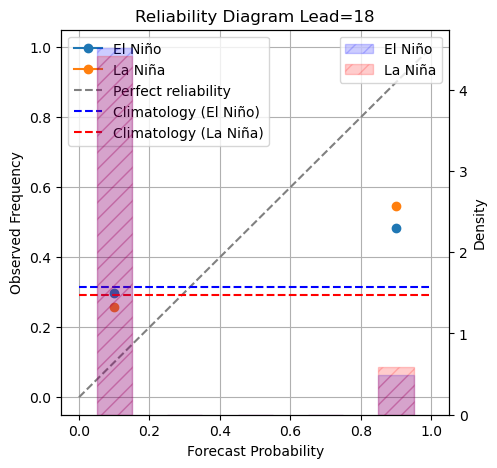

In [269]:
for lead in leads:
    
    FOR_index=np.zeros((1,24000))
    FOR_index.shape
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities)
    plt.show()

# Old Fig 13

In [26]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [27]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

In [28]:
import xskillscore as xs

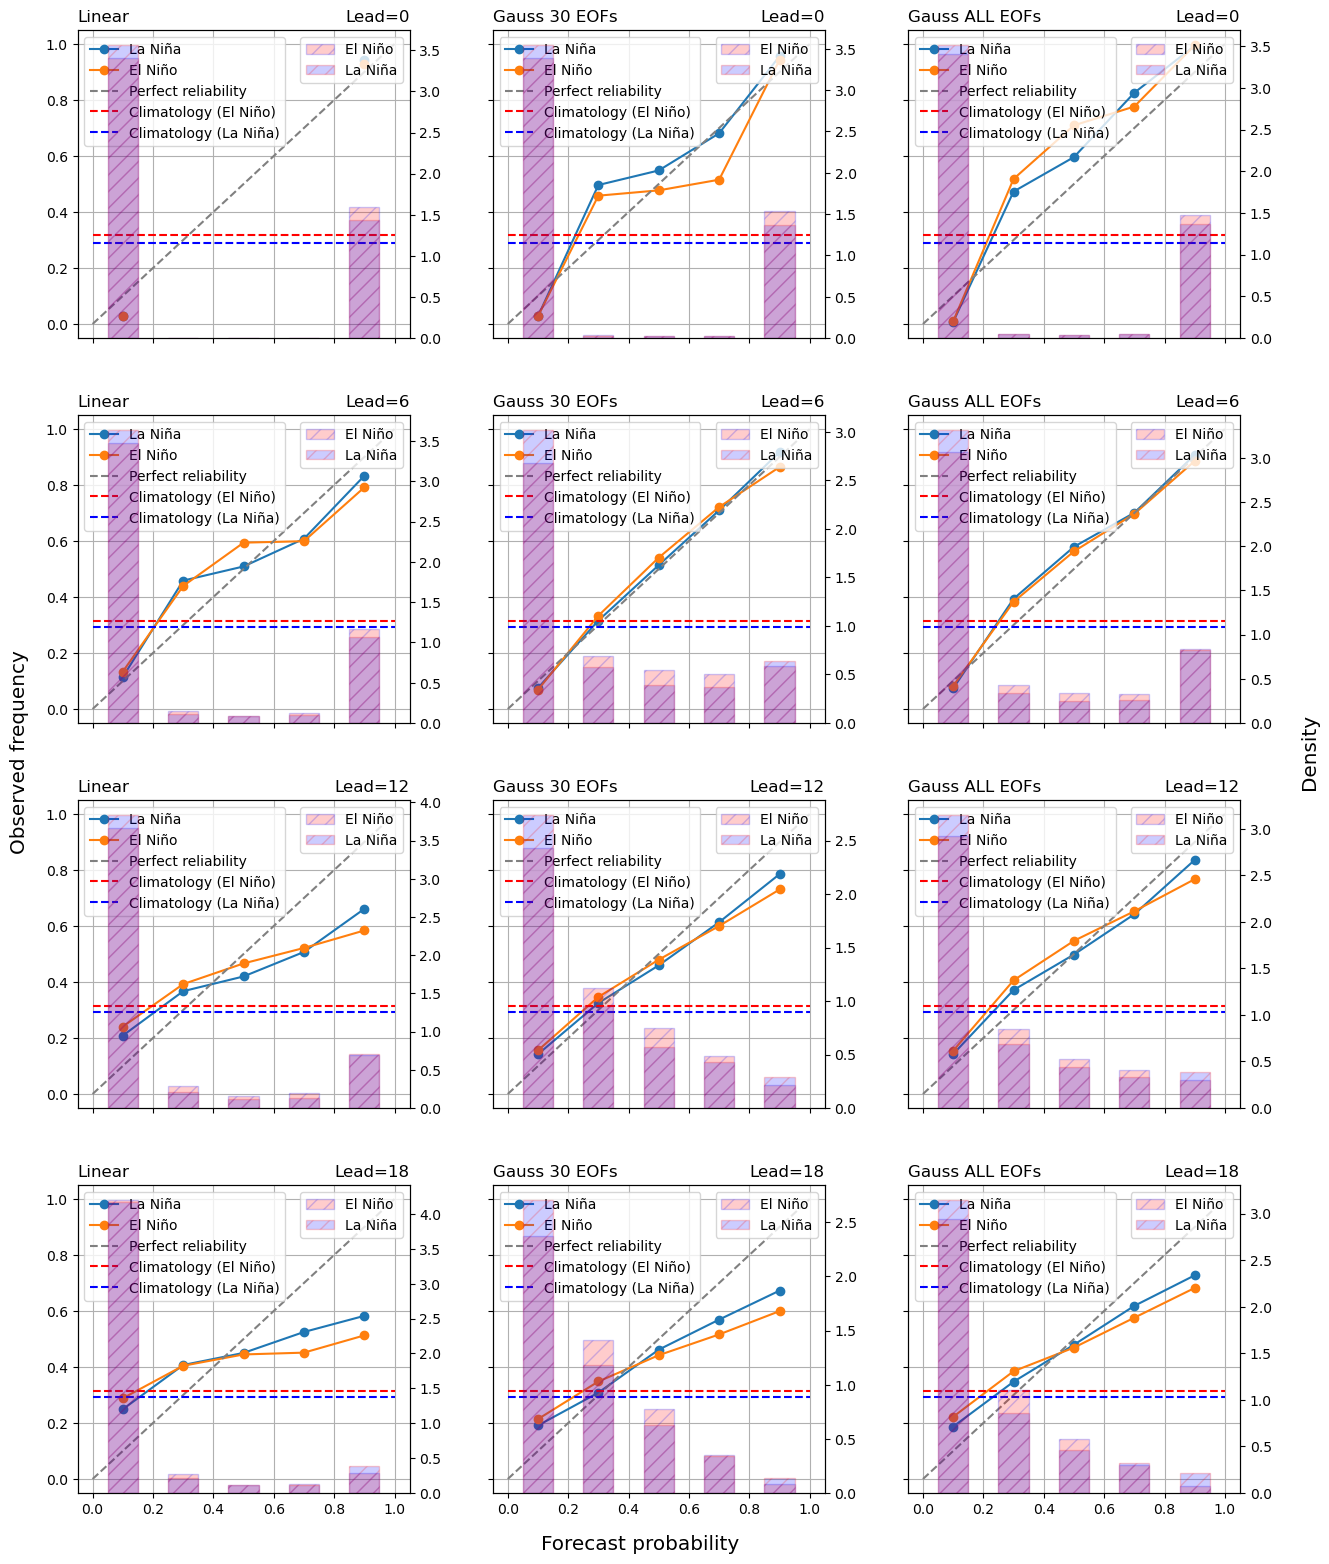

In [75]:
columns = 3
rows = 4

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,19),sharey=True,sharex=True)


##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[k,0], title_kernel='Linear')


##################################################################
#############          GAUSS 30             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[k,1], title_kernel='Gauss 30 EOFs')


##################################################################
#############          GAUSS ALL             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[k,2], title_kernel='Gauss ALL EOFs')

fig.text(0.5, 0.08, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.94, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('Fig 13.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 13.jpg', orientation='landscape',  format='jpg')
plt.show() 

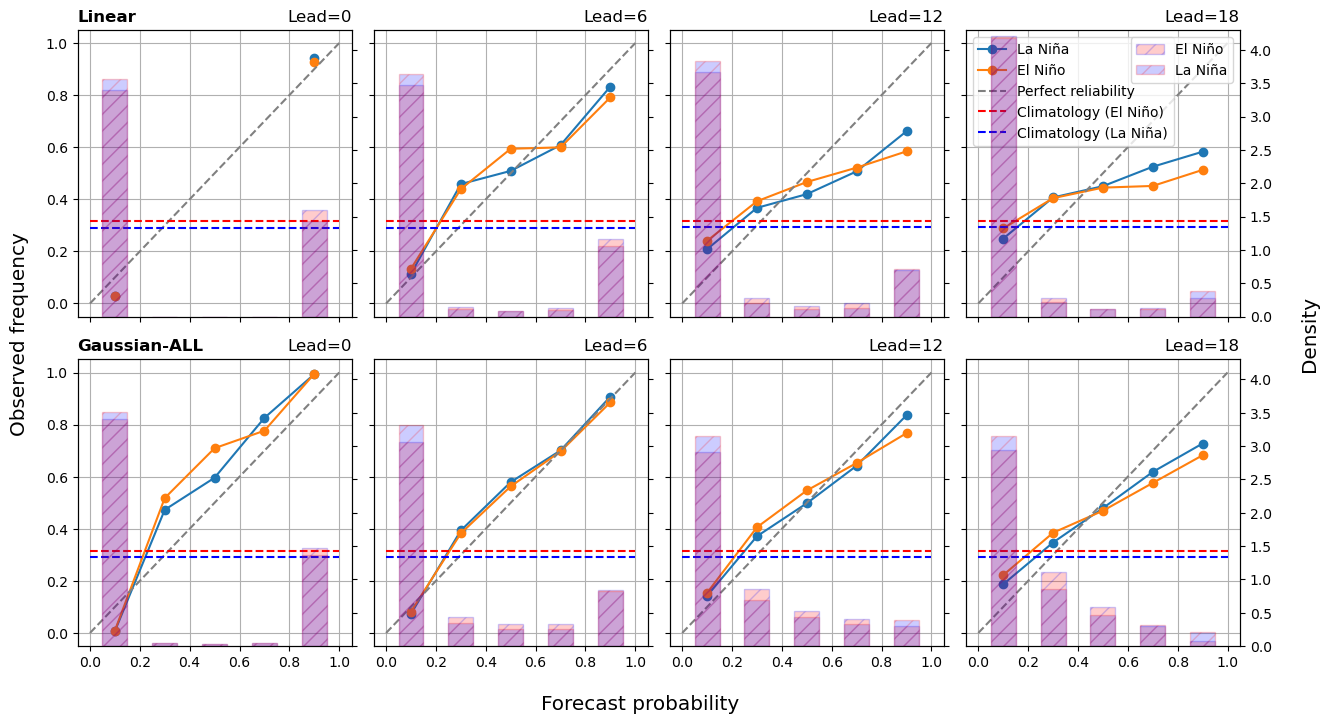

In [27]:
columns = 4
rows = 2

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,8),sharey=True,sharex=True)


##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title_kernel='Linear'
    else:
        title_kernel=''

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    

    plot_reliability_his1(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)
    
##################################################################
#############          GAUSS ALL             ######################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==0:
        title_kernel='Gaussian-ALL'
    else:
        title_kernel=''

    if k==3:
        ticks=True
    else:
        ticks=False

    legend=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, 0.5)
    
    # Example usage:
    plot_reliability_his1(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)

fig.text(0.5, 0.03, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.94, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.08, hspace=0.15)
plt.savefig('Fig 13-bis.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 13-bis.jpg', orientation='landscape',  format='jpg')
plt.show() 

In [37]:
#Case study
niño_probabilities[236]

0.5

In [38]:
##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union_L=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

In [39]:
##################################################################
#############          GAUSS ALL             ######################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union_G=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

0.59088105
G0 = 0.5193684981633311        L0 = 0.500247570045695   
G1 = 0.5783976355995599        L1 = 0.5002475700456941   
G2 = 0.426511502245678        L2 = 0.5002475700456961   
G3 = 0.49853303097567125        L3 = 0.5002475700456978   


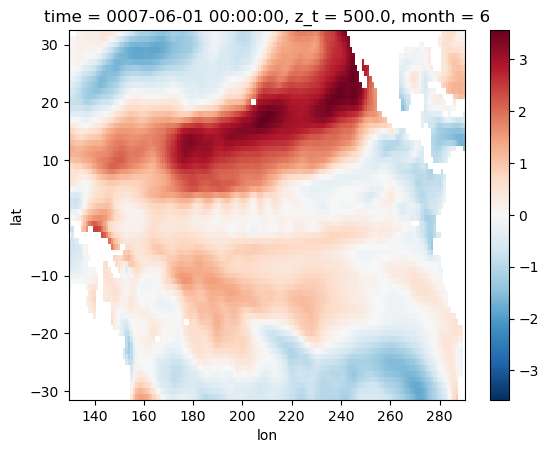

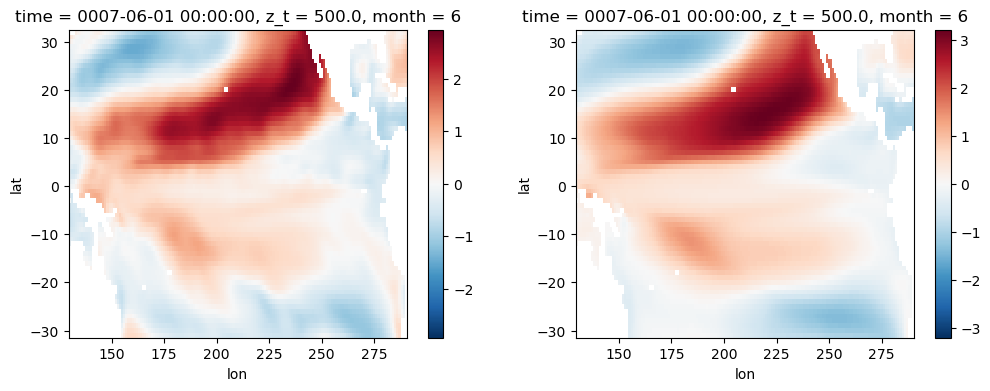

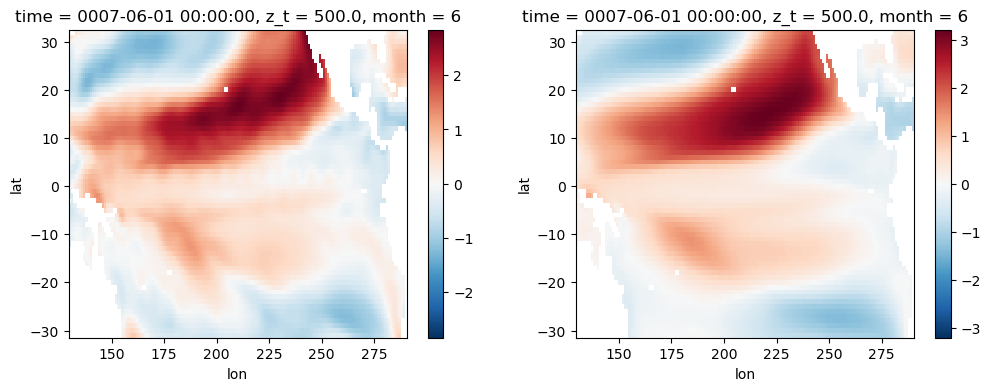

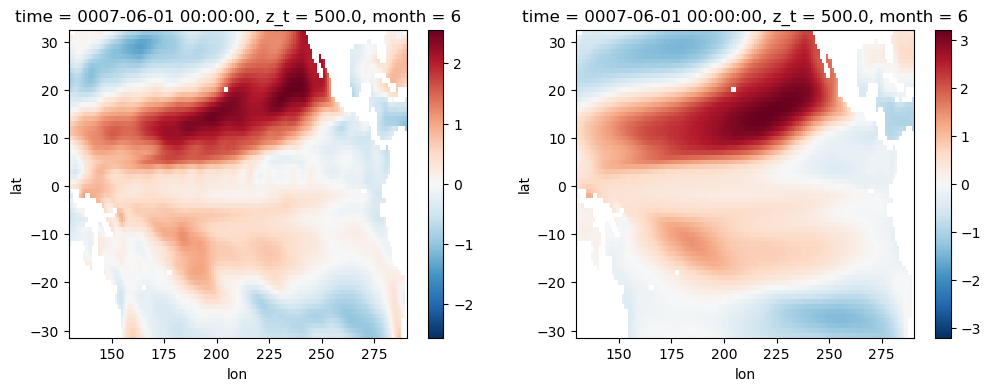

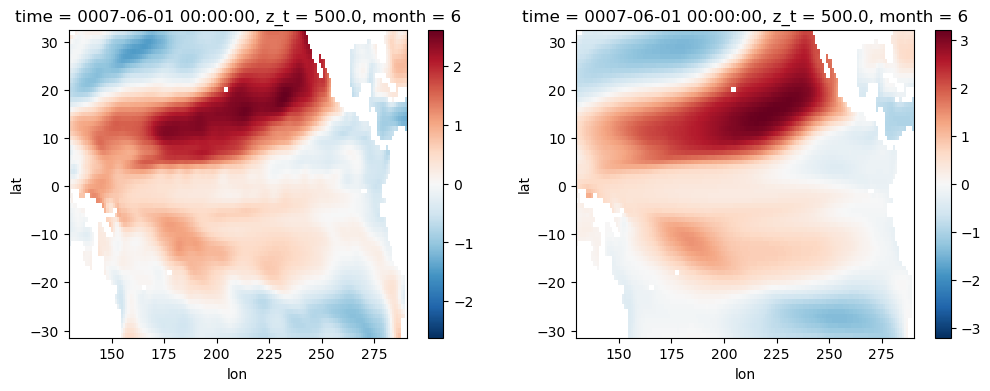

In [55]:
k=0
lead=leads[k]

tstep=76


X_tos.A.unstack().isel(time=tstep).plot()
print(X_tos.A.unstack().isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon')).data)

for i in range(4): 
    #Gauss
    phix_geo_array=udat_sst @ tot_for_union_G[i,0:845,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_G=phix_geo.unstack()
    IndG= Phiindex_G.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Linear
    
    phix_geo_array=udat_sst[:,0:20] @ tot_for_union_L[i,0:20,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_L=phix_geo.unstack()
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,4) )
    Phiindex_G.isel(time=tstep).plot(ax=axs[0])
    Phiindex_L.isel(time=tstep).plot(ax=axs[1])
    IndL= Phiindex_L.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    print(f'G{i} = {IndG.data}        L{i} = {IndL.data}   ')

0.43143135
G0 = 0.5322722121245186        L0 = 0.374065472061569   
G1 = 0.48541931645722525        L1 = 0.3740654720615681   
G2 = 0.48116833660881736        L2 = 0.37406547206156815   
G3 = 0.5338693565418522        L3 = 0.37406547206156904   


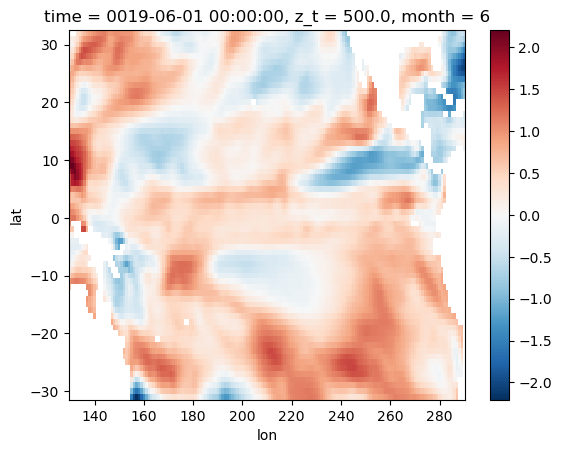

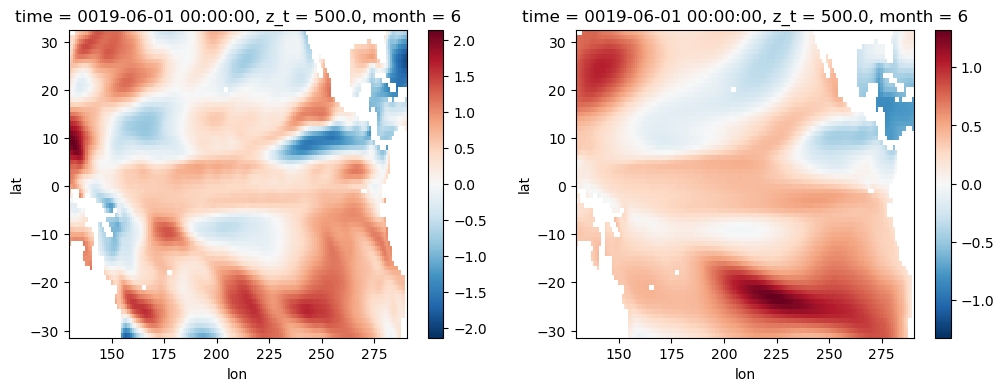

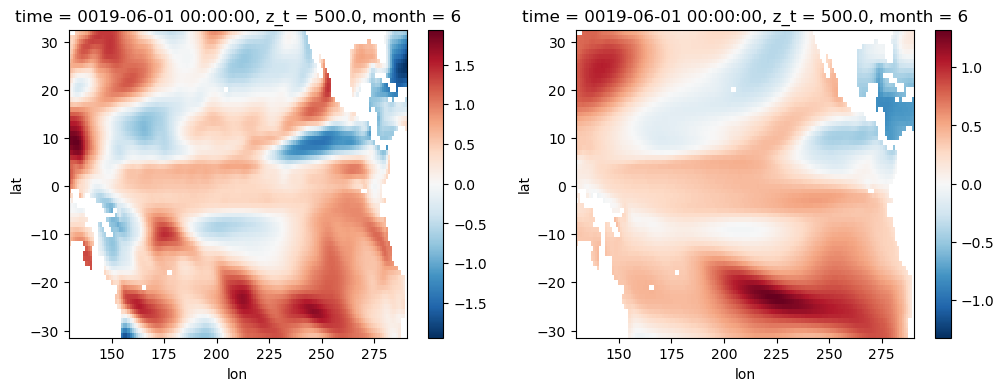

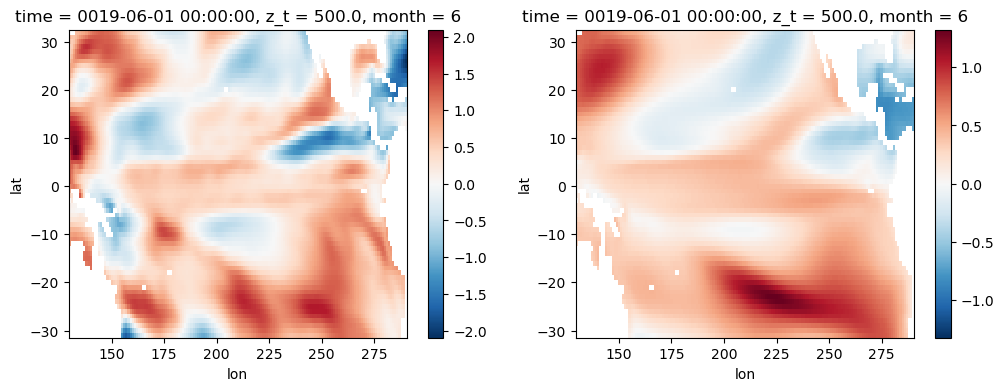

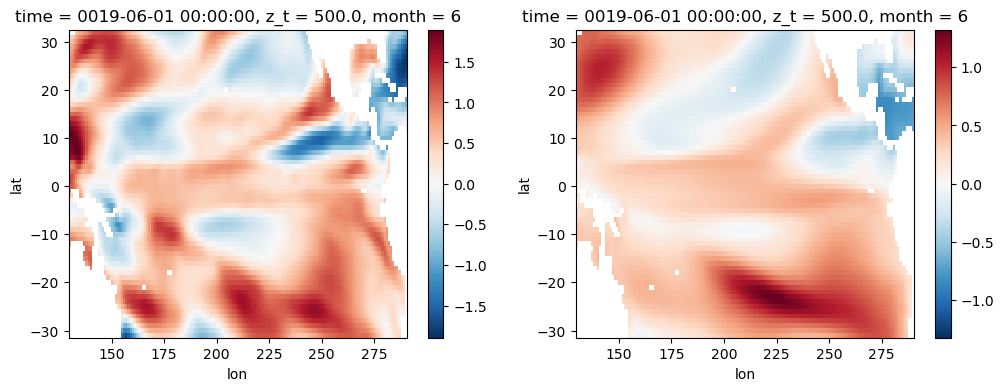

In [56]:
k=0
lead=leads[k]

tstep=220

X_tos.A.unstack().isel(time=tstep).plot()
print(X_tos.A.unstack().isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon')).data)

for i in range(4): 
    #Gauss
    phix_geo_array=udat_sst @ tot_for_union_G[i,0:845,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_G=phix_geo.unstack()
    IndG= Phiindex_G.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Linear
    
    phix_geo_array=udat_sst[:,0:20] @ tot_for_union_L[i,0:20,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_L=phix_geo.unstack()
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,4) )
    Phiindex_G.isel(time=tstep).plot(ax=axs[0])
    Phiindex_L.isel(time=tstep).plot(ax=axs[1])
    IndL= Phiindex_L.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    print(f'G{i} = {IndG.data}        L{i} = {IndL.data}   ')

0.4517262
G0 = 0.5463811539281282        L0 = 0.578394614594297   
G1 = 0.5158221469735219        L1 = 0.5783946145942918   
G2 = 0.4716776812594938        L2 = 0.5783946145942948   
G3 = 0.45224522534387246        L3 = 0.578394614594296   


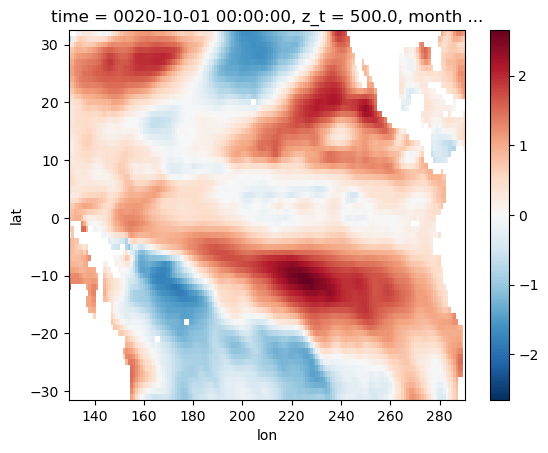

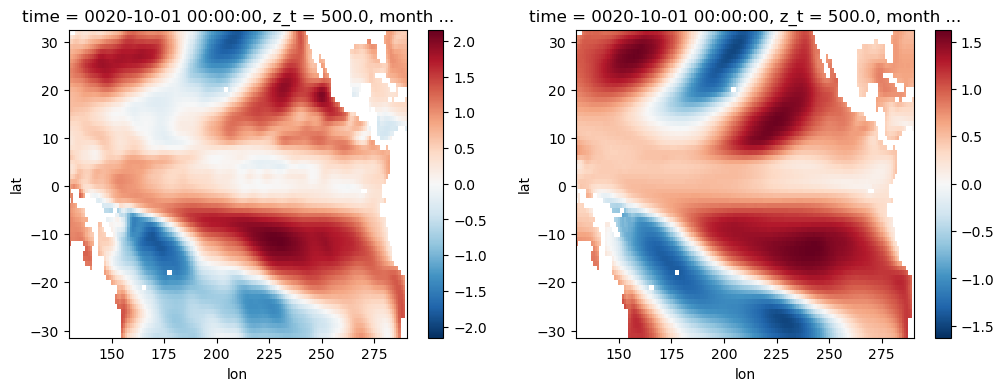

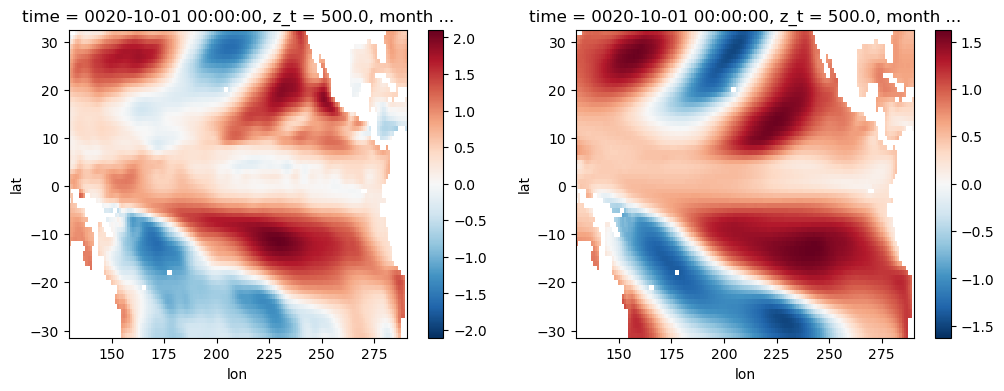

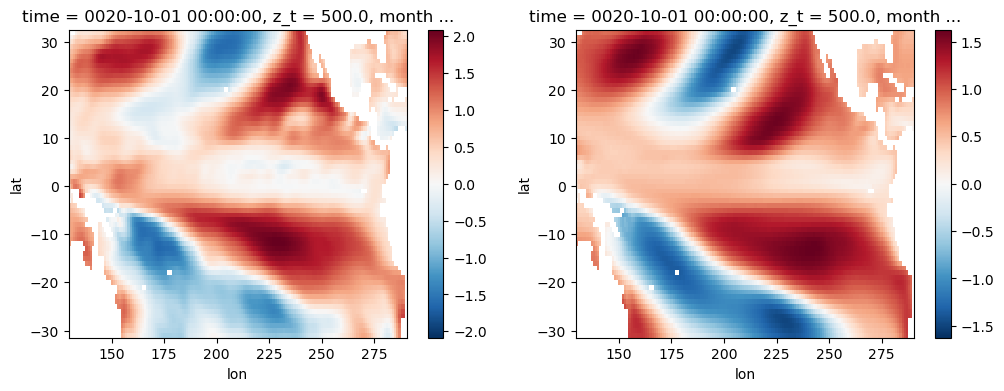

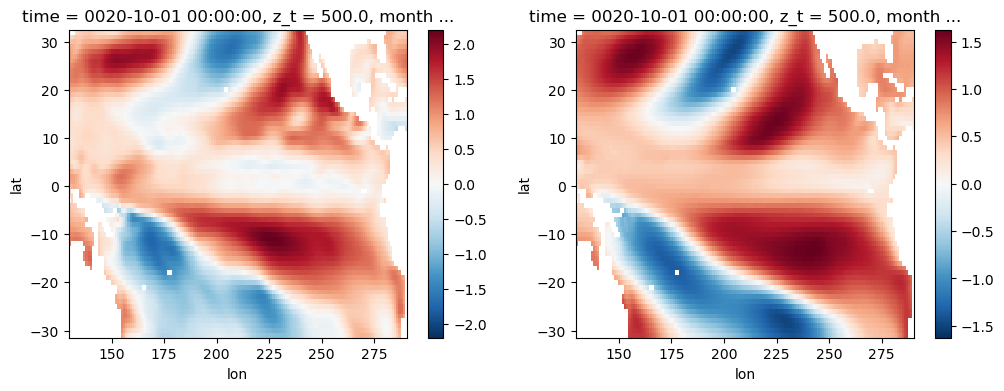

In [57]:
k=0
lead=leads[k]

tstep=236

X_tos.A.unstack().isel(time=tstep).plot()
print(X_tos.A.unstack().isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon')).data)

for i in range(4): 
    #Gauss
    phix_geo_array=udat_sst @ tot_for_union_G[i,0:845,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_G=phix_geo.unstack()
    IndG= Phiindex_G.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Linear
    
    phix_geo_array=udat_sst[:,0:20] @ tot_for_union_L[i,0:20,lead,:]  
    phix_geo = xr.full_like(X_tos.A[:,:],0)
    phix_geo.data=phix_geo_array.real
    Phiindex_L=phix_geo.unstack()
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,4) )
    Phiindex_G.isel(time=tstep).plot(ax=axs[0])
    Phiindex_L.isel(time=tstep).plot(ax=axs[1])
    IndL= Phiindex_L.isel(time=tstep).sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    print(f'G{i} = {IndG.data}        L{i} = {IndL.data}   ')

### 

# Old Fig 13 remake

In [41]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [42]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

In [43]:
import xskillscore as xs

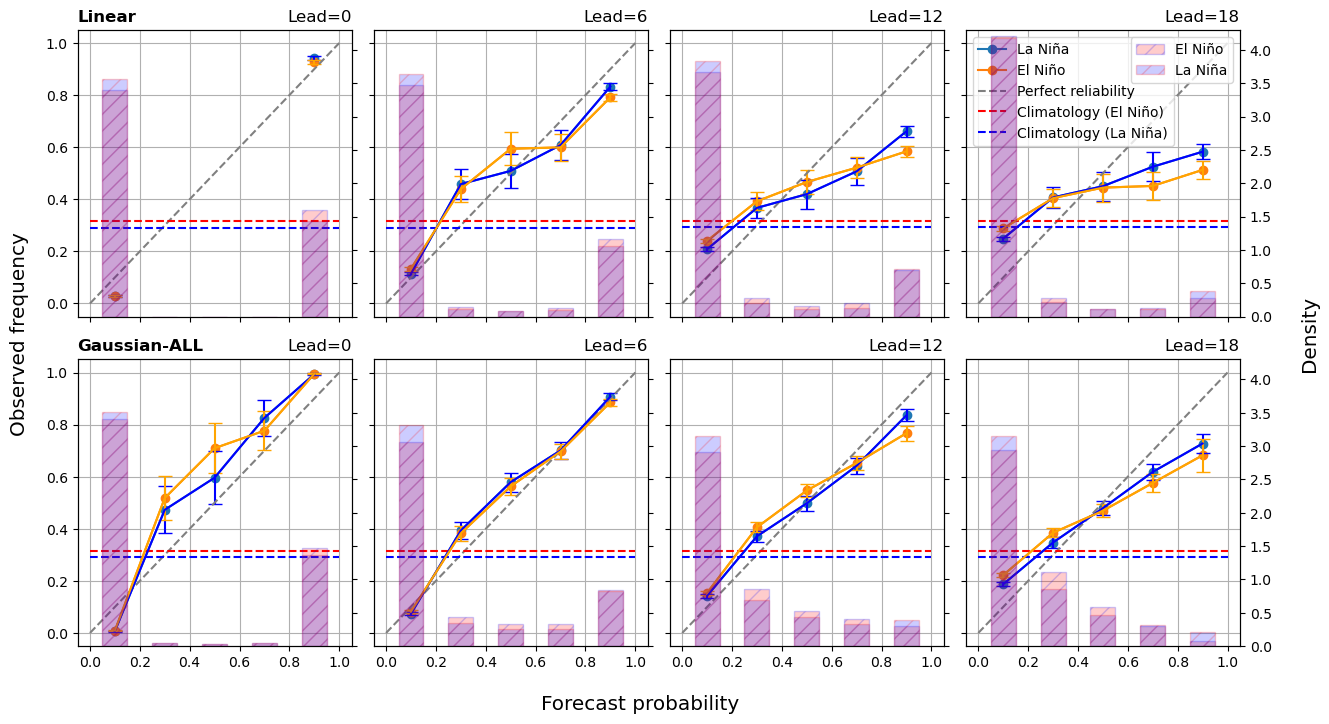

In [54]:
columns = 4
rows = 2

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,8),sharey=True,sharex=True)


##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title_kernel='Linear'
    else:
        title_kernel=''

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold, -threshold)
    

    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)
    
##################################################################
#############          GAUSS ALL             ######################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==0:
        title_kernel='Gaussian-ALL'
    else:
        title_kernel=''

    if k==3:
        ticks=True
    else:
        ticks=False

    legend=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold, -threshold)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)

fig.text(0.5, 0.03, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.94, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.08, hspace=0.15)
#plt.savefig('Fig 13-bis.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 13-bis.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Fig 9 Terciles (from observations)

In [29]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [30]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

In [31]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [32]:
threshold_niño=np.percentile(Xindex, 67.7)
print(threshold_niño)

threshold_niña=np.percentile(Xindex, 33.3)
print(threshold_niña)

0.47868241342902185
-0.38134550043940546


In [36]:
np.load(f'Forecasts 200/POLY_forecast_p{0}.npy').shape

(17, 30, 24, 1176)

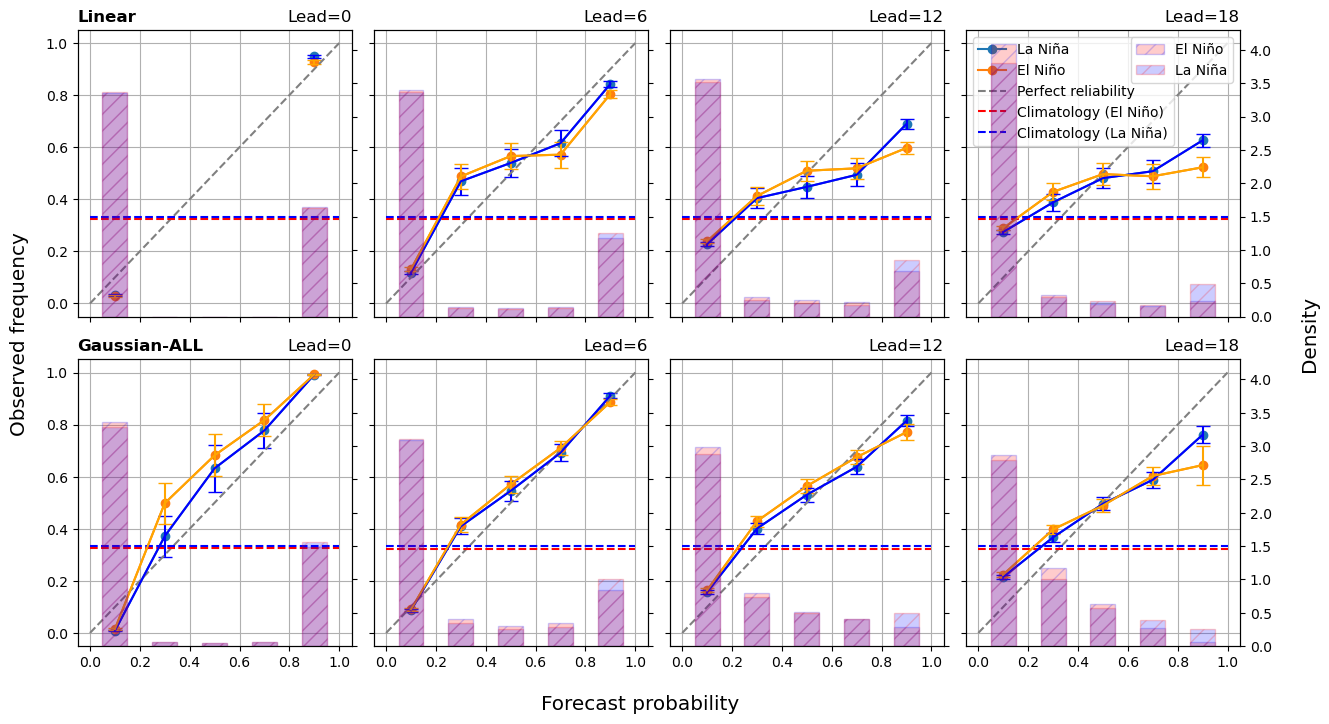

In [35]:
columns = 4
rows = 2

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,8),sharey=True,sharex=True)

##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 17, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title_kernel='Linear'
    else:
        title_kernel=''

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_niño, threshold_niña)
    

    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)
    
##################################################################
#############          GAUSS ALL             ######################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 17, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==0:
        title_kernel='Gaussian-ALL'
    else:
        title_kernel=''

    if k==3:
        ticks=True
    else:
        ticks=False

    legend=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_niño, threshold_niña)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)

fig.text(0.5, 0.03, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.94, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.08, hspace=0.15)
plt.savefig('Fig 9.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 9.jpg', orientation='landscape',  format='jpg')
plt.show()

# Thresholds (observations & forecasts)

In [57]:
threshold_niño=np.percentile(Xindex, 67)
print(threshold_niño)

threshold_niña=np.percentile(Xindex, 33)
print(threshold_niña)

0.4592961585521698
-0.39044301450252533


Linear lead= 0 ,  0.47669568488569175   -0.3720445709001791
Linear lead= 1 ,  0.3715416064161611   -0.2841132468956402
Linear lead= 2 ,  0.28650586236406006   -0.19511579076816107
Linear lead= 3 ,  0.20032210884337542   -0.1497022617019796
Gaussian lead= 0 ,  0.44456829504840184   -0.37209997917360826
Gaussian lead= 1 ,  0.3740340267842544   -0.2819138460713451
Gaussian lead= 2 ,  0.2783161905656778   -0.21640792541271525
Gaussian lead= 3 ,  0.22093525122148436   -0.16431787115569055


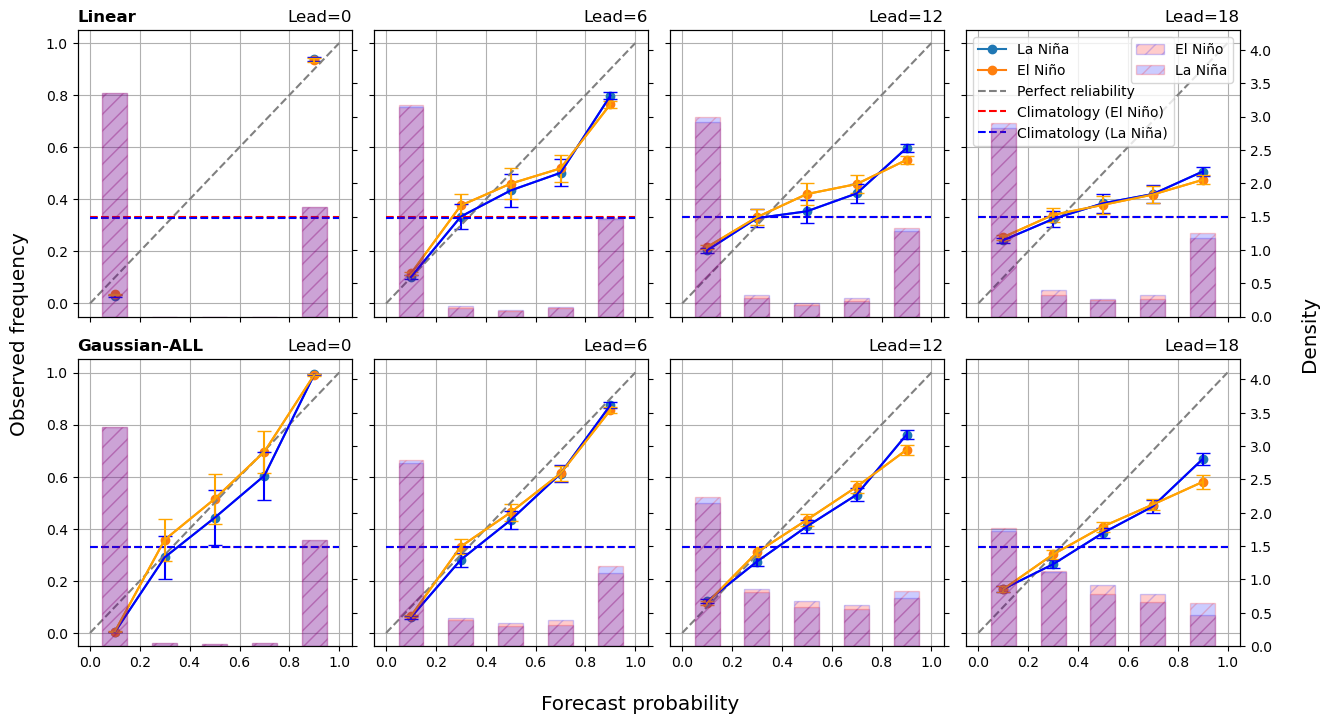

In [59]:
columns = 4
rows = 2

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,8),sharey=True,sharex=True)

##################################################################
#############          POLY             ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:20]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 30, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title_kernel='Linear'
    else:
        title_kernel=''

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    mean_FOR=np.mean(FOR_index, axis=0)
    threshold_for_niño=np.nanpercentile(mean_FOR, 67)
    threshold_for_niña=np.nanpercentile(mean_FOR, 33)
    print('Linear lead=', k, ', ', threshold_for_niño, ' ', threshold_for_niña )
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_for_niño, threshold_for_niña)
    

    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)
    
##################################################################
#############          GAUSS ALL             ######################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

for k in range(len(leads)):

    if k==0:
        title_kernel='Gaussian-ALL'
    else:
        title_kernel=''

    if k==3:
        ticks=True
    else:
        ticks=False

    legend=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
        
    mean_FOR=np.mean(FOR_index, axis=0)
    threshold_for_niño=np.nanpercentile(mean_FOR, 67)
    threshold_for_niña=np.nanpercentile(mean_FOR, 33)
    print("Gaussian lead=", k, ", ", threshold_for_niño, ' ', threshold_for_niña)
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_for_niño, threshold_for_niña)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title_kernel, legend=legend, ticks=ticks, limit=4.3)

fig.text(0.5, 0.03, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.94, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.08, hspace=0.15)
#plt.savefig('Fig 13-bis.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 13-bis.jpg', orientation='landscape',  format='jpg')
plt.show()

# Old Fig 14

In [24]:
## Load EOFsee
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [25]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,6,12,18]

In [26]:
import xskillscore as xs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


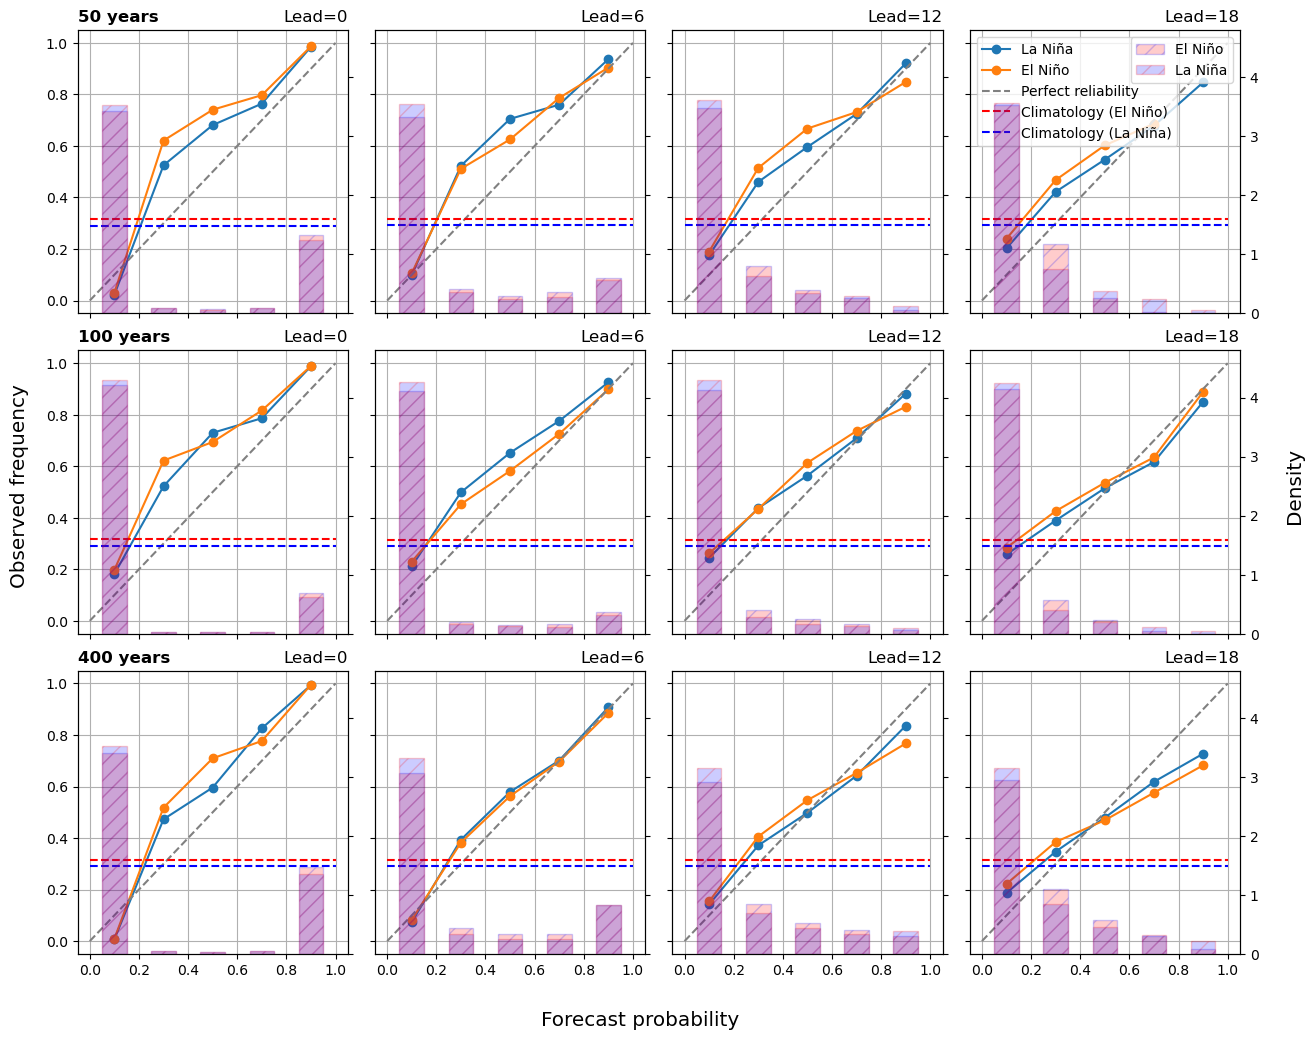

In [25]:
#Threshold 0.5
columns = 4
rows = 3
legend=False

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,12),sharey=True,sharex=True)


##################################################################
#############          50                ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:845]

Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

tot_for_union=np.empty((38, 845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    print(m)
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

#Plots

for k in range(len(leads)):
    
    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title='50 years'
    else:
        title=''

    lead=leads[k]
    FOR_index=np.zeros((38,24000))
    FOR_index.shape
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold)
    
    # Example usage:
    plot_reliability_his1(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)


##################################################################
#############                100             #####################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 19, 1845, 24, 1176))
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

del(tot_for)

#Plots

legend= False
for k in range(len(leads)):

    if k==0:
        title='100 years'
    else:
        title=''

    if k==3:
        ticks=True
    else:
        ticks=False

    lead=leads[k]
    FOR_index=np.zeros((19,24000))
    FOR_index.shape
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold)
    
    # Example usage:
    plot_reliability_his1(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)


##################################################################
#############              400               ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

legend=False
for k in range(len(leads)):

    if k==0:
        title='400 years'
    else:
        title=''

    if k==3:
        ticks=True
    else:
        ticks=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    threshold=0.5
    niño_binary = np.where(obs > threshold, 1, 0)
    niña_binary = np.where(obs < -threshold, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold)
    
    # Example usage:
    plot_reliability_his1(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[2,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)

fig.text(0.5, 0.05, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.93, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.1, hspace=0.13)
plt.savefig('Fig 14-bis.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 14-bis.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Old figure 14 but with Terciles (observations + forecasts)

In [27]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [28]:
threshold_niño=np.percentile(Xindex, 67)
print(threshold_niño)

threshold_niña=np.percentile(Xindex, 33)
print(threshold_niña)

0.4592961585521698
-0.39044301450252533


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
50 lead= 0 ,  0.4083588393177137   -0.3586707448527653
50 lead= 1 ,  0.3179024794269436   -0.23443106270855013
50 lead= 2 ,  0.20948246094887127   -0.1549681233262838
50 lead= 3 ,  0.18165117468637157   -0.1432950753494124
100 lead= 0 ,  0.42538409208972927   -0.36317737610929807
100 lead= 1 ,  0.3501403429754793   -0.24815923556044753
100 lead= 2 ,  0.23959898940333577   -0.164808203489025
100 lead= 3 ,  0.19964673043556713   -0.14130283513564298
400 lead= 0 ,  0.44456829504840184   -0.37209997917360826
400 lead= 1 ,  0.3740340267842544   -0.2819138460713451
400 lead= 2 ,  0.2783161905656778   -0.21640792541271525
400 lead= 3 ,  0.22093525122148436   -0.16431787115569055


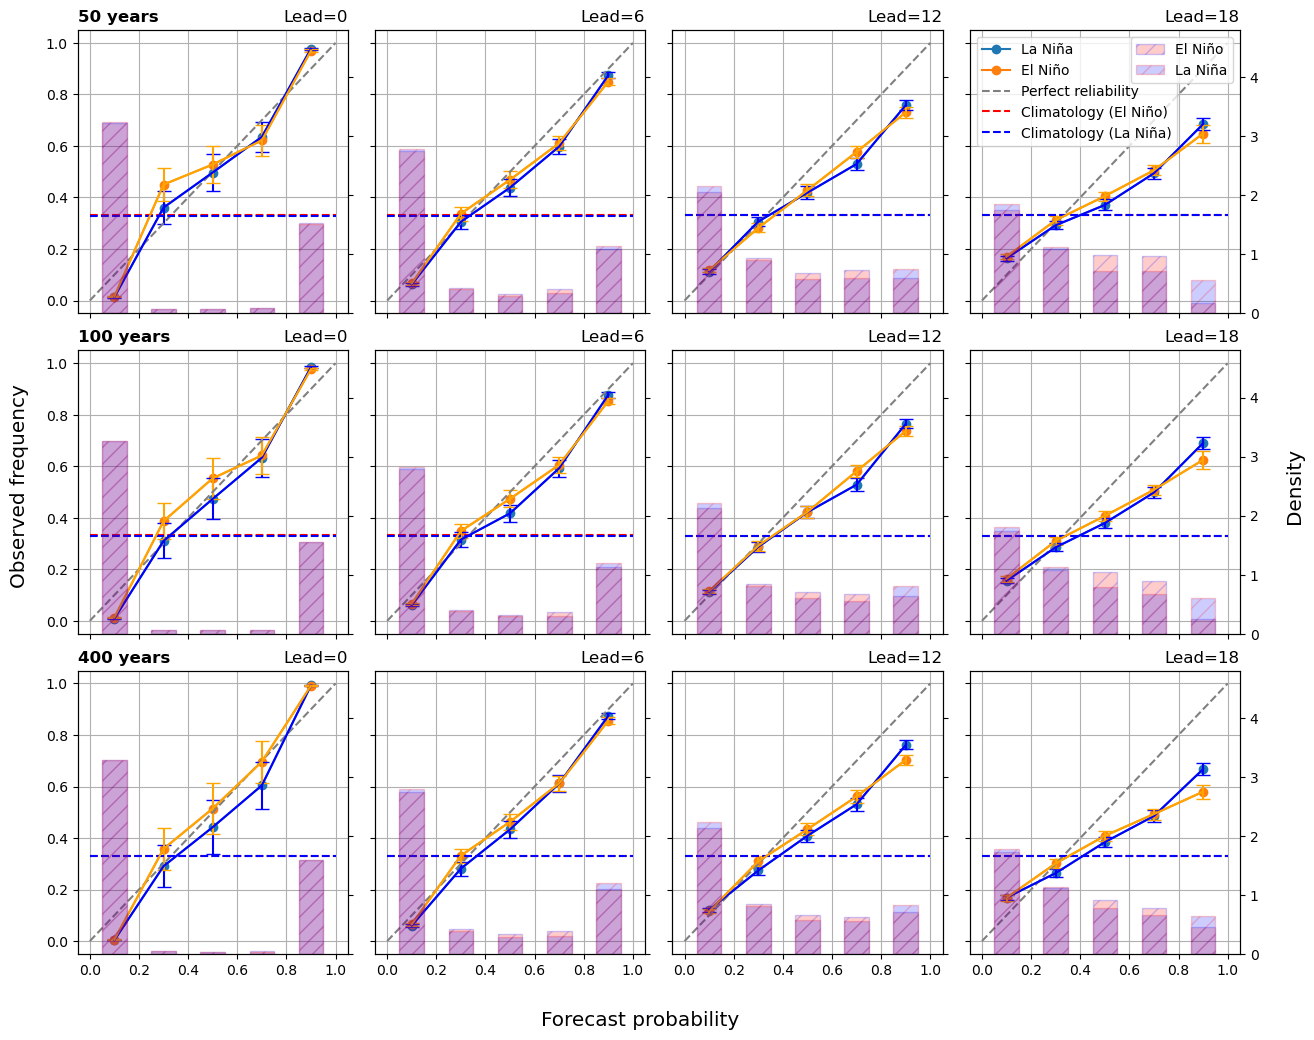

In [68]:
#Threshold 0.5
columns = 4
rows = 3
legend=False

from pylab import *

fig, ax = plt.subplots(rows, columns,figsize=(15,12),sharey=True,sharex=True)


##################################################################
#############          50                ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:845]

Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

tot_for_union=np.empty((38, 845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    print(m)
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

#Plots

for k in range(len(leads)):
    
    if k==3:
        legend=True
        ticks=True
    else:
        legend=False
        ticks=False

    if k==0:
        title='50 years'
    else:
        title=''

    lead=leads[k]
    FOR_index=np.zeros((38,24000))
    FOR_index.shape
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data

    mean_FOR=np.mean(FOR_index, axis=0)
    threshold_for_niño=np.nanpercentile(mean_FOR, 67)
    threshold_for_niña=np.nanpercentile(mean_FOR, 33)
    print("50 lead=", k, ", ", threshold_for_niño, ' ', threshold_for_niña)
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_for_niño, threshold_for_niña)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[0,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)


##################################################################
#############                100             #####################
##################################################################


# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 19, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

del(tot_for)

#Plots

legend= False
for k in range(len(leads)):

    if k==0:
        title='100 years'
    else:
        title=''

    if k==3:
        ticks=True
    else:
        ticks=False

    lead=leads[k]
    FOR_index=np.zeros((19,24000))
    FOR_index.shape
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data

    mean_FOR=np.mean(FOR_index, axis=0)
    threshold_for_niño=np.nanpercentile(mean_FOR, 67)
    threshold_for_niña=np.nanpercentile(mean_FOR, 33)
    print("100 lead=", k, ", ", threshold_for_niño, ' ', threshold_for_niña)
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_for_niño, threshold_for_niña)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[1,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)


##################################################################
#############              400               ######################
##################################################################

# Load data
udat_sst=EOFs[:,0:845]
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]

tot_for=np.zeros((20, 7, 1845, 24, 1176))
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
del(tot_for)

#Plots

legend=False
for k in range(len(leads)):

    if k==0:
        title='400 years'
    else:
        title=''

    if k==3:
        ticks=True
    else:
        ticks=False

    lead=leads[k]
    FOR_index=np.zeros((4,24000))
    FOR_index.shape
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
    
        FOR_index[i,:]=Phiindex.data

    mean_FOR=np.mean(FOR_index, axis=0)
    threshold_for_niño=np.nanpercentile(mean_FOR, 67)
    threshold_for_niña=np.nanpercentile(mean_FOR, 33)
    print("400 lead=", k, ", ", threshold_for_niño, ' ', threshold_for_niña)
    
    
    
    # REMOVE NaNs
    obs=Xindex[np.invert(np.isnan(FOR_index[0,:]))]
    forecasts=FOR_index[:,np.invert(np.isnan(FOR_index[0,:]))]
    
    # BINARY OBSERVATIONS IN DATARRAY FORM
    niño_binary = np.where(obs > threshold_niño, 1, 0)
    niña_binary = np.where(obs < threshold_niña, 1, 0)
    
    # PROBABILISTIC FORECAST IN DATARRAY FORM    
    niño_probabilities, niña_probabilities = compute_forecast_probabilities(forecasts, threshold_for_niño, threshold_for_niña)
    
    # Example usage:
    plot_reliability_his_err(niño_binary, niña_binary, niño_probabilities, niña_probabilities, ax=ax[2,k], title_kernel=title, legend=legend, limit=4.8, ticks=ticks)

fig.text(0.5, 0.05, 'Forecast probability', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Observed frequency', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.93, 0.5, 'Density', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.1, hspace=0.13)
#plt.savefig('Fig 14-bis.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 14-bis.jpg', orientation='landscape',  format='jpg')
plt.show() 